# Setup

In [236]:
import pandas as pd
import numpy as np
import os

# To serialise models
from sklearn.externals import joblib

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns

# plt.rcParams['axes.labelsize'] = 12
# plt.rcParams['xtick.labelsize'] = 9
# plt.rcParams['ytick.labelsize'] = 9
# plt.rcParams['axes.titlesize'] = 18
# plt.rcParams['figure.dpi'] = 400

plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 18


# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=400):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


PROCESSED_PATH = os.path.join(PROJECT_ROOT_DIR, "processed")
def save_processed(df, filename, extension="csv"):
    if not os.path.isdir(PROCESSED_PATH):
        os.makedirs(PROCESSED_PATH)
    path = os.path.join(PROCESSED_PATH, filename + "." + extension)
    print("Saving processed dataset", filename)
    df.to_csv(path, index=False)
    
# if less than R1K, show as R800 (for eg). If btw R1000 and R999,999, show as R1K or R999K. If R1,000,000 or greater, show as R1M
def currency_formatter(x, pos):
    if x >= 1000000:
        return 'R%1.1fM' % (x * 1e-6)
    elif x < 1000:
        return 'R%1.1d' % (x)
    else:
        return 'R%1.1dK' % (x * 1e-3) 
    
axes_formatter = FuncFormatter(currency_formatter) 

# Download & Process Zomato Data

In [2]:
API_KEY = "0ce0b2e48571f88facd08f8efd3569aa"
ENTITY_TYPE = "city"
SORT_BY = "rating"
SORT_ORDER = ["desc", "asc"]
RAW_FOLDER = "raw/"
PROCESSED_FOLDER = "processed/"

In [3]:
def load_data(base_path, file, sub_dir=None, ext="csv", encoding=None):
    filename = file + "." + ext
    if sub_dir is not None:
        csv_path = os.path.join(base_path, sub_dir, filename)
    else:
        csv_path = os.path.join(base_path, filename)
    return pd.read_csv(csv_path)

In [6]:
city_ids = load_data(RAW_FOLDER, "zomato_city_ids")
city_ids.head()

Country       City  Zomato ID
0  South Africa  Cape Town         64

In [7]:
import requests
import json

def get_categories():
    # Get all zomato categories.
    # Categories are global and not unique to a specific country.
    headers = {"user-key": API_KEY}
    response=requests.get("https://developers.zomato.com/api/v2.1/categories", headers=headers)
    json_data = response.json()
    
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)
    file_name = "categories.json"
    file_path = os.path.join(RAW_FOLDER, file_name)
    
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)
        
    # return all the category id's for restaurant search function.  
    cat_ids = [category["categories"]["id"] for category in json_data["categories"]]
    return cat_ids
        
def get_establishment_type_for_city(city_id):
    # Finding all establishment types in city_id and writing to file
    headers = {"user-key": API_KEY}
    params = {"city_id": city_id}
    response=requests.get("https://developers.zomato.com/api/v2.1/establishments", 
                          headers=headers, params=params)
    json_data = response.json()
       
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)    
    file_name = "establishment_types_" + str(city_id) + "." + "json"
    file_path = os.path.join(RAW_FOLDER, file_name)
    
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)
        
    # return all the establishment type id's for restaurant search function.  
    establishment_ids = [establishment["establishment"]["id"] for establishment in json_data["establishments"]]
    return establishment_ids
        
def get_cuisine_type_for_city(city_id):
    # Finding all cuisine types in Cape Town and writing to file
    headers = {"user-key": API_KEY}
    params = {"city_id": city_id}
    response=requests.get("https://developers.zomato.com/api/v2.1/cuisines", 
                          headers=headers, params=params)
    json_data = response.json()
    
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)    
    file_name = "cuisine_types_" + str(city_id) + "." + "json"
    file_path = os.path.join(RAW_FOLDER, file_name)
    
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)
        
    # return all the cuisine type id's for restaurant search function.
    cuisine_ids = [cuisine["cuisine"]["cuisine_id"] for cuisine in json_data["cuisines"]]
    return cuisine_ids

In [8]:
def download_with_criteria(headers, city_id, file_path, iterable_list, iterable_name, sort_order, is_item_list=False):
    json_dump = []
    
    # if API is not expecting a list for iterable_name, then run through each value as as search criteria
    if not is_item_list:        
        for item in iterable_list:
            start = 0
            results_shown = 20
            while results_shown != 0:                
                params = {"entity_id": city_id, "entity_type": ENTITY_TYPE, "start": start, 
                          "count": 20, iterable_name: item,"sort": SORT_BY, 
                          "order": sort_order}
                response=requests.get("https://developers.zomato.com/api/v2.1/search", 
                                  headers=headers, params=params)

                json_data = response.json()
                results_shown = int(json_data.get("results_shown", 0))

                if results_shown == 0:
                    break

                # appending each dictionary to a list so that json.load() can process 
                # multiple dictionaries
                json_dump.append(json.dumps(json_data))     

                start += 20
    
    # otherwise pass the full list to iterable_name, such as cuisine's. 
    # note: initially it was attempted to run through the above loop for every cuisine type, but allowed API calls 
    # where exceeded for a single city download attempt. 
    else:
        start = 0
        results_shown = 20
        while results_shown != 0:            
            params = {"entity_id": city_id, "entity_type": ENTITY_TYPE, "start": start, 
                      "count": 20, iterable_name: iterable_list,"sort": SORT_BY, 
                      "order": sort_order}
            response=requests.get("https://developers.zomato.com/api/v2.1/search", 
                              headers=headers, params=params)

            json_data = response.json()
            results_shown = int(json_data.get("results_shown", 0))

            if results_shown == 0:
                break

            # appending each dictionary to a list so that json.load() can process 
            # multiple dictionaries
            json_dump.append(json.dumps(json_data))     

            start += 20
        
            
    
    # each dictionary must exist as a list object for json.load to read it correctly    
    with open(file_path, 'w') as outfile:
        outfile.write("[")
        count = 0
        for item in json_dump:
            outfile.write(item)
            if count < len(json_dump)-1:
                outfile.write(",")
            count += 1
        outfile.write("]")

In [9]:
def get_restaurants(city_id, establishment_types):
     # Find 100 top rated restaurants of each establishment type, category and cuisine type per city and write to file
    headers = {"user-key": API_KEY}
    
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)
    
    search_criteria = ["Category", "Establishment Type", "Cuisine Type"]
    city_name = city_ids[city_ids["Zomato ID"] == city_id]["City"].values[0]

    # Download restaurant for city by establishment type
    print("Downloading restaurants for", city_name, "by", search_criteria[1])
    
    for sort_order in SORT_ORDER:
        file_name = "restaurants_by_establishment_type_" + str(city_id) + "_" + sort_order + "." + "json"
        file_path = os.path.join(RAW_FOLDER, file_name)
        download_with_criteria(headers, city_id, file_path, establishment_types, "establishment_type", 
                               sort_order, is_item_list=False)
    print("Done")

In [18]:
for city_id in city_ids["Zomato ID"]:
    establishments = get_establishment_type_for_city(city_id)
    get_restaurants(city_id, establishments)

Done


In [10]:
# For each city, we need to combine the restaurant data from the categories-based, establishment type-based and cuisine-based json files. 

def build_csv(city_id, source_type):
    restaurants_list = []
    for sort_order in SORT_ORDER:
        file_name = "restaurants_by_" + source_type + "_" + str(city_id) + "_" + sort_order + ".json"
        source_path = os.path.join(RAW_FOLDER, file_name)

        db = json.load(open(source_path))

        restaurant_cols = ["name", 
                           "cuisines",
                           "aggregate_rating", 
                           "rating_text", 
                           "votes",
                           "currency", 
                           "average_cost_for_two", 
                           "price_range",                    
                           "locality",
                           "locality_verbose",
                           "city", 
                           "zipcode",
                           "country_id",
                           "latitude", 
                           "longitude",                                       
                           "has_online_delivery", 
                           "has_table_booking", 
                           ]

        restaurants = [restaurant_group["restaurant"] for count_group in db 
                           for restaurant_group in count_group["restaurants"]] 

        for restaurant in restaurants:
            restaurant["locality"] = restaurant["location"]["locality"]
            restaurant["locality_verbose"] = restaurant["location"]["locality_verbose"]
            restaurant["city"] = restaurant["location"]["city"]
            restaurant["latitude"] = restaurant["location"]["latitude"]
            restaurant["longitude"] = restaurant["location"]["longitude"]
            restaurant["zipcode"] = restaurant["location"]["zipcode"]
            restaurant["country_id"] = restaurant["location"]["country_id"]
            restaurant["aggregate_rating"] = restaurant["user_rating"]["aggregate_rating"]
            restaurant["votes"] = restaurant["user_rating"]["votes"]
            restaurant["rating_text"] = restaurant["user_rating"]["rating_text"]
            
        restaurants_list.append(restaurants)
        
    df1 = pd.DataFrame(restaurants_list[0], columns=restaurant_cols)
    df2 = pd.DataFrame(restaurants_list[1], columns=restaurant_cols)
    return pd.concat([df1, df2])
    

def process_restaurants_json(city_id):
    
    source_types = ["establishment_type"]
    dfs = []
    for source in source_types:
        dfs.append(build_csv(city_id, source))
    
    if not os.path.isdir(PROCESSED_FOLDER):
         os.makedirs(PROCESSED_FOLDER) 
    
    file_name = "restaurants_" + str(city_id) + ".csv"
    output_path = os.path.join(PROCESSED_FOLDER, file_name)

    data = pd.concat(dfs)
    data.to_csv(output_path, encoding='utf-8-sig', index=False)
    

In [32]:
for city in city_ids["Zomato ID"]:
    process_restaurants_json(city)

# Data Preparation

In [123]:
data = load_data(PROCESSED_FOLDER, 'restaurants_64')
data.shape

(1970, 17)

In [124]:
data.head()

name                            cuisines  aggregate_rating  \
0          Moro Gelato                 Desserts, Ice Cream               4.8   
1   Unframed Ice Cream                           Ice Cream               4.7   
2  The Velvet Cake Co.                    Bakery, Desserts               4.6   
3         The Creamery                 Desserts, Ice Cream               4.5   
4             My Sugar  Cafe, Patisserie, Bakery, Desserts               4.5   

  rating_text  votes currency  average_cost_for_two  price_range   locality  \
0   Excellent     72        R                    80            1        CBD   
1   Excellent    104        R                    40            1    Gardens   
2   Excellent     90        R                   165            2        CBD   
3   Excellent    389        R                   110            2   Newlands   
4   Excellent    197        R                   125            2  Sea Point   

       locality_verbose       city  zipcode  country_id   latitude  longitude  \
0        CBD, Cape Town  Cape Town      NaN         189 -33.924108  18.417317   
1    Gardens, Cape Town  Cape Town      NaN         189 -33.928691  18.412097   
2        CBD, Cape Town  Cape Town      NaN         189 -33.919300  18.421512   
3   Newlands, Cape Town  Cape Town      NaN         189 -33.970286  18.461950   
4  Sea Point, Cape Town  Cape Town      NaN         189 -33.921692  18.382759   

   has_online_delivery  has_table_booking  
0                    0                  0  
1                    0                  0  
2                    0                  0  
3                    0                  0  
4                    0                  0

## Remove Duplicates

Since we downloaded the top 100 and bottom 100 restuarants of each category, there is likely to be some duplication as certain categories contain less than 200 restaurants meaning that the same establishment could appear near the bottom of the top 100 or the top of the bottom 100. There are many restaurant franchises in Cape Town, so we'll define a duplicate as a restaurant with the same name at the same locality.

In [125]:
data[data.duplicated(subset=["name", "locality"])]

name  \
87                         N' Ice   
156                  Vida E Caffe   
162                         Kauai   
299                The Fat Cactus   
301         Rick's Cafe Americain   
302             Beerhouse on Long   
303           Bombay Bicycle Club   
500           Warwick Wine Estate   
502                      My Sugar   
503           The Velvet Cake Co.   
514                        tashas   
515                   Yoco Eatery   
518                        tashas   
533                            Nü   
599              Burger & Lobster   
600            Jerry's Burger Bar   
601          The Shortmarket Club   
603            Jerry's Burger Bar   
605             The Village Idiot   
606            Outrage of Modesty   
609            Jerry's Burger Bar   
700                Aces 'n Spades   
715           The Velvet Cake Co.   
716               New York Bagels   
717                  Jason Bakery   
718                    The Larder   
720                    Max Bagels   
721                         Knead   
722                Oumeul Bakkery   
723                          Lust   
...                           ...   
1940          Daytona Pub & Venue   
1941             Zebonkey Brewery   
1942                       Cassis   
1943                   Coco Safar   
1944                        Yummi   
1945              Créme de Levain   
1946              Créme de Levain   
1947              High Tea Tighty   
1948     TonyH Artisan Chocolates   
1949                         Njam   
1950                Kreativ juice   
1951                  Las Paletas   
1952           The Pickled Popper   
1953              Earthfire Pizza   
1954                      The Nob   
1955      Didi's Bitchin Burritos   
1956              Earthfire Pizza   
1957            Sugary Sensations   
1958             Crumbs and Cream   
1959                         Como   
1960        Black Box Coffeeworks   
1961     Chameleon Mobile Kitchen   
1962               Sliced Between   
1963             The Chef’s Bench   
1964                  Sunset Cafe   
1965  Harringtons Cocktail Lounge   
1966     Oh La La Cocktail Lounge   
1967   The Polynesian Pearl Diver   
1968                 Moody Lagoon   
1969       Seabreeze Fish & Shell   

                                               cuisines  aggregate_rating  \
87                                  Ice Cream, Desserts               0.0   
156                                      Cafe, Desserts               3.3   
162                             Healthy Food, Fast Food               3.3   
299                       Mexican, Finger Food, Tex-Mex               4.1   
301       Moroccan, Grill, Seafood, Burger, Finger Food               3.9   
302                                       Grill, German               3.9   
303                   Mediterranean, Steak, Finger Food               3.9   
500                  South African, Mediterranean, Cafe               4.6   
502                  Cafe, Patisserie, Bakery, Desserts               4.5   
503                              Cafe, Desserts, Bakery               4.4   
514                                 Cafe, Mediterranean               4.2   
515           Cafe, Burger, Contemporary, International               4.2   
518                                 Mediterranean, Cafe               4.1   
533                                  Healthy Food, Cafe               4.0   
599                                     Seafood, Burger               4.4   
600                                    Burger, American               4.3   
601                                              French               4.3   
603                                    Burger, American               4.1   
605                                South African, Grill               4.0   
606                                       International               4.0   
609                                    Burger, American               3.9   
700                                     

In [126]:
data.duplicated(subset=["name", "locality"]).sum()

614

In [127]:
# duplicates are considerd those restaurants with the same name in the same location. Keep the first instance.
data = data.drop_duplicates(subset=["name", "locality"], keep='first')
data.shape

(1356, 17)

## Removing Unneccessary Columns

In [128]:
#removing currency, country, locality_verbose and zipcode
cols = ['name', 'cuisines', 'aggregate_rating', 'rating_text', 'votes',
       'average_cost_for_two', 'price_range', 'locality', 'city',
       'latitude', 'longitude', 'has_online_delivery', 'has_table_booking']
data = data[cols]
data.head()

name                            cuisines  aggregate_rating  \
0          Moro Gelato                 Desserts, Ice Cream               4.8   
1   Unframed Ice Cream                           Ice Cream               4.7   
2  The Velvet Cake Co.                    Bakery, Desserts               4.6   
3         The Creamery                 Desserts, Ice Cream               4.5   
4             My Sugar  Cafe, Patisserie, Bakery, Desserts               4.5   

  rating_text  votes  average_cost_for_two  price_range   locality       city  \
0   Excellent     72                    80            1        CBD  Cape Town   
1   Excellent    104                    40            1    Gardens  Cape Town   
2   Excellent     90                   165            2        CBD  Cape Town   
3   Excellent    389                   110            2   Newlands  Cape Town   
4   Excellent    197                   125            2  Sea Point  Cape Town   

    latitude  longitude  has_online_delivery  has_table_booking  
0 -33.924108  18.417317                    0                  0  
1 -33.928691  18.412097                    0                  0  
2 -33.919300  18.421512                    0                  0  
3 -33.970286  18.461950                    0                  0  
4 -33.921692  18.382759                    0                  0

## Fix Restaurants with Missing Geographic Info

We'll also identify restaurants that don't have their latitude and longitude specified as we'll be using these parameters during the analysis. Where possible, we'll fill in these values by looking up the restaurant info on Google Maps. If we can't find the info, we'll remove the restaurant from the analysis. 

In [129]:
data[(data["longitude"] == 0) & (data["latitude"] == 0)]

name                               cuisines  \
41                  Jessy's Waffles                               Desserts   
91                          DV Café              Desserts, Cafe, Ice Cream   
130                    Vida E Caffe                         Cafe, Desserts   
134                    Lekker Vegan                              Fast Food   
361                    The Vic Bar                       American, Italian   
641              Ben's On the Beach                          Grill, Burger   
774   La Bella Rosa Bistro & Coffee                   Cafe, Burger, Bakery   
826                 The Common Room                            Finger Food   
937      Jack Rabbit Mobile Kitchen  Fast Food, Street Food, South African   
1431                           Moyo                                African   
1540               The White Rabbit                                   Cafe   
1663       Company Social Brasserie                           Contemporary   

      aggregate_rating rating_text  votes  average_cost_for_two  price_range  \
41                 3.2     Average     11                   100            2   
91                 0.0   Not rated      0                    50            1   
130                3.5        Good     17                   150            2   
134                3.4     Average     28                   200            3   
361                3.0     Average      6                     0            1   
641                3.6        Good     58                   320            4   
774                2.8     Average      4                   160            2   
826                0.0   Not rated      0                    70            1   
937                0.0   Not rated      3                   100            2   
1431               3.4     Average     86                   561            4   
1540               2.7     Average      5                     0            1   
1663               3.1     Average     10                     0            1   

                     locality       city  latitude  longitude  \
41                    Gardens  Cape Town       0.0        0.0   
91    Spice Route Farm, Paarl  Cape Town       0.0        0.0   
130                 Camps Bay  Cape Town       0.0        0.0   
134                       CBD  Cape Town       0.0        0.0   
361                   Gardens  Cape Town       0.0        0.0   
641                    Strand  Cape Town       0.0        0.0   
774               Durbanville  Cape Town       0.0        0.0   
826                       CBD  Cape Town       0.0        0.0   
937               Durbanville  Cape Town       0.0        0.0   
1431                 Newlands  Cape Town       0.0        0.0   
1540         V & A Waterfront  Cape Town       0.0        0.0   
1663             Stellenbosch  Cape Town       0.0        0.0   

      has_online_delivery  has_table_booking  
41                      0                  0  
91                      0                  0  
130                     0                  0  
134                     0                  0  
361                     0                  0  
641                     0                  0  
774                     0                  0  
826                     0                  0  
937                     0                  0  
1431                    0                  0  
1540                    0                  0  
1663                    0                  0

In [130]:
data.loc[41, "latitude"] = -33.9314912; data.loc[41, "longitude"] = 18.416589
data.loc[91, "latitude"] = -33.7643602; data.loc[91, "longitude"] = 18.9180991
data.loc[130, "latitude"] = -33.9511; data.loc[130, "longitude"] = 18.3763713
data.loc[134, "latitude"] = -33.9284282; data.loc[134, "longitude"] = 18.4215289
data.loc[361, "latitude"] = -33.9330936; data.loc[361, "longitude"] = 18.4058024
data.loc[641, "latitude"] = -34.1115314; data.loc[641, "longitude"] = 18.819894
data.loc[774, "latitude"] = -33.833121; data.loc[774, "longitude"] = 18.6438816
data.loc[826, "latitude"] = -33.926449; data.loc[826, "longitude"] = 18.4454532
data.loc[1431, "latitude"] = -33.988727; data.loc[1431, "longitude"] = 18.4313973
data.loc[1540, "latitude"] = -33.9036187; data.loc[1540, "longitude"] = 18.4183216
data.loc[1663, "latitude"] = -33.9358607; data.loc[1663, "longitude"] = 18.8564851

In [131]:
data[(data["longitude"] == 0) & (data["latitude"] == 0)]

name                               cuisines  \
937  Jack Rabbit Mobile Kitchen  Fast Food, Street Food, South African   

     aggregate_rating rating_text  votes  average_cost_for_two  price_range  \
937               0.0   Not rated      3                   100            2   

        locality       city  latitude  longitude  has_online_delivery  \
937  Durbanville  Cape Town       0.0        0.0                    0   

     has_table_booking  
937                  0

The only restaurant we couldn't find location information for was Jack Rabbit Mobile Kitchen. This makes sense since it sounds like a food truck that doesn't have a fixed location. We'll remove it.

In [132]:
data = data[(data["longitude"] != 0) & (data["latitude"] != 0)]
data[(data["longitude"] == 0) & (data["latitude"] == 0)]

Empty DataFrame
Columns: [name, cuisines, aggregate_rating, rating_text, votes, average_cost_for_two, price_range, locality, city, latitude, longitude, has_online_delivery, has_table_booking]
Index: []

We know these are South African restaurants, so all their latitude values should be negative and all their longitude values positive, let's check this.

In [133]:
data[data["latitude"] > 0]

name                                     cuisines  \
643                    The 41  Contemporary, Seafood, Mediterranean, Sushi   
685            Pearl Mountain                                  Drinks Only   
868   Groot Constantia Winery                                  Drinks Only   
1665       Anura Tasting Room                                  Drinks Only   
1841  The Trading Post Eatery                                   Cafe, Deli   

      aggregate_rating rating_text  votes  average_cost_for_two  price_range  \
643                3.5        Good     29                   400            4   
685                3.3     Average      7                    50            1   
868                3.9        Good     52                    90            1   
1665               3.1     Average      5                   100            2   
1841               3.0     Average      5                   200            3   

                                      locality       city   latitude  \
643                                  Camps Bay  Cape Town  33.948688   
685          Pearl Mountain Wine Estate, Paarl  Cape Town  33.702186   
868   Groot Constantia Wine Estate, Constantia  Cape Town  34.026732   
1665                                    Anura   Cape Town  33.804110   
1841                                    Anura   Cape Town  33.811946   

      longitude  has_online_delivery  has_table_booking  
643   18.376794                    0                  0  
685   18.995174                    0                  0  
868   18.422542                    0                  0  
1665  18.884110                    0                  0  
1841  18.885821                    0                  0

In [134]:
f = lambda x: -x if x > 0 else x
data.latitude = data.latitude.apply(f)
data[data["latitude"] > 0]

Empty DataFrame
Columns: [name, cuisines, aggregate_rating, rating_text, votes, average_cost_for_two, price_range, locality, city, latitude, longitude, has_online_delivery, has_table_booking]
Index: []

In [135]:
data[data["longitude"] < 0]

Empty DataFrame
Columns: [name, cuisines, aggregate_rating, rating_text, votes, average_cost_for_two, price_range, locality, city, latitude, longitude, has_online_delivery, has_table_booking]
Index: []

## Add Dummy Columns for Each Cuisine Type

We'd like to have a true/false value for each cuisine type. This will make it easier to count restaurants by specific cuisine types later. Zomato piles all the cuisines together in a single comma seperated field, so we need to break this up first and then create dummies.

In [136]:
# Values in cuisine columns may have multiple values with ',' seperator
# Extract each possible cuisine type then ensure each dummy column is prefixed with "cuisine_"

dummies = data['cuisines'].str.get_dummies(sep=", ")
dummies.columns = ["cuisine_" + str(col) for col in dummies.columns]
data = pd.concat([data, dummies], axis=1)
print(data.shape)
data.sample(10)

(1355, 86)


name  \
598                             Olami   
449   The Restaurant at Clos Malverne   
1105                           Steers   
84                         Milky Lane   
1678         Solms Delta Tasting Room   
1603             Newton Johnson Wines   
374                  The Nameless Pub   
895              Cape Point Vineyards   
289                   Banana Jam Cafe   
664                 La Parada Del Mar   

                                               cuisines  aggregate_rating  \
598   Cafe, Middle Eastern, Deli, Mediterranean, Hea...               3.8   
449                             African, Seafood, Steak               3.9   
1105                                          Fast Food               2.4   
84                                             Desserts               0.0   
1678                                        Drinks Only               3.1   
1603                                        Drinks Only               2.8   
374                                         Drinks Only               2.9   
895                                             Italian               3.7   
289                     Grill, Burger, Pizza, Caribbean               3.9   
664                                      Spanish, Tapas               3.4   

     rating_text  votes  average_cost_for_two  price_range  \
598         Good     45                   250            3   
449         Good     53                   450            4   
1105        Poor     13                   135            2   
84     Not rated      1                    80            1   
1678     Average     10                    80            1   
1603     Average      7                    60            1   
374      Average      4                   120            2   
895         Good     55                   400            4   
289         Good    243                   250            3   
664      Average     27                   400            4   

                           locality       city   latitude         ...          \
598                             CBD  Cape Town -33.925915         ...           
449                    Stellenbosch  Cape Town -33.910833         ...           
1105  Canal Walk Mall, Century City  Cape Town -33.892667         ...           
84           N1 City Mall, Goodwood  Cape Town -33.891864         ...           
1678                    Franschhoek  Cape Town -33.863971         ...           
1603                       Hermanus  Cape Town -34.367718         ...           
374                   Somerset West  Cape Town -34.085738         ...           
895                       Noordhoek  Cape Town -34.099202         ...           
289     Harfield Village, Claremont  Cape Town -33.994322         ...           
664                       Camps Bay  Cape Town -33.950130         ...           

      cuisine_Steak  cuisine_Street Food  cuisine_Sushi  cuisine_Tapas  \
598               0                    0              0              0   
449               1                    0              0              0   
1105              0                    0              0              0   
84                0                    0              0              0   
1678              0                    0              0              0   
1603              0                    0              0              0   
374               0                    0              0              0   
895               0                    0              0              0   
289               0                    0              0              0   
664               0                    0              0              1   

      cuisine_Tea  cuisine_Tex-Mex  cuisine_Thai  cuisine_Turkish  \
598             0                0             0                0   
449             0                0             0                0   
1105            0                0             0                0   
84              0                0             0                0  

## Extract a Place of Interest from Locality and Store in New Column
Some restaurants are part of a place of interest such as a shopping mall or hotel. This is specified in the locality as a comma-seperated pair. We'll split these out into their own column and use "None" where it doesn't apply. This allows us to investigate rating trends at specific shopping malls, for example.

In [137]:
# Go through each row and extract a place value from the locality if one is specified
# Store the place and locality seperately in order to filter more precisely

places = []
localities = []
def split_locality(row):
    items = row["locality"].split(',')
    if len(items) > 1:
        places.append(items[0])
        localities.append(items[1].strip())
    else:
        places.append("None")
        localities.append(items[0].strip())
        
       
data.apply(split_locality, axis=1)
data["places"] = places
data["locality"] = localities

In [138]:
data[["locality", "places"]].sample(10)

locality                  places
166          Claremont                    None
128          Claremont                    None
1264          Newlands                    None
1538       Franschhoek                    None
592         Constantia                    None
1408  V & A Waterfront          Victoria Wharf
96            Hout Bay       Bay Habour Market
683           Blouberg  Eden On The Bay Centre
1893        Wellington                    None
1097           Rylands                    None

## Fix Localities Incorrectly Entered Into Zomato
A number of localities were found with spelling mistakes leading to an incorrect representation of the data. While we could exclude these I would rather try fix them manually so as to keep as much data as possible for the analysis.

In [139]:
mapping = {
    "Dubanville": "Durbanville",
    "Contantia": "Constantia",
    "Tableview": "Table View",
    "Belville":"Bellville",
    "Belvile":"Bellville",
    "Bellvile":"Bellville",
    "V&A Waterfront":"V & A Waterfront",
    "The Woodstock Exchange. Woodstock": "Woodstock",
    "Franschoek":"Franschhoek",
    "Somersetwest":"Somerset West",
    "Kuilsriver":"Kuils River",
    "Greenpoint":"Green Point",
    "Ridgeback Wine Farm": "Paarl",
    "Anura": "Stellenbosch",
    "Hannover": "Hanover Park",
    "NH The Lord Charles Hotel": "Somerset West",
    "Fairbridge Mall": "Brackenfell",
    "Blouberg": "Bloubergstrand",
    "Two Oceans Beach": "Mouille Point",
}

def correct_incorrect_localities(col):
    if col in mapping:
        return mapping.get(col, 'None')
    else:
        return col
    
#data["locality"] = data["locality"].apply(correct_incorrect_localities)

# If no mapping provided, return x
f = lambda x: mapping.get(x, x)
data.locality = data.locality.map(f)

## Build Web Scraper & Add Region Column to Visualise Larger Geographical Areas

In addition to the locality/suburb, we'd like to visualise larger regional trends as well. To do this, we'll scrape a list of Cape Town suburbs and their associated regions from https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs. 

We'll export the suburb/region match to its own data file, then for each restaurant in our dataset, we will match its locality to this list of suburbs and assign the fitting region to a new column in the main dataset.

In [140]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

response = requests.get('https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs')
content = response.content
parser = BeautifulSoup(content, 'html.parser')

#Finding all regions in th Wiki page - these have the .mw-headline class
regions_list = [region.text for region in parser.select(".mw-headline")]
suburbs_by_region = {}                    

# The .wikitable class is assigned to each table of suburbs per region    
regions = parser.select(".wikitable")  

count = 0
for region in regions:
    # Finding each suburb while skipping columns with postal codes
    # Some fields have additional info in (), so splitting on those and removing
    suburbs = [suburb.text.split('(')[0] for suburb in region.select("td")[::3]]
    
    for suburb in suburbs:
        suburbs_by_region[suburb] = regions_list[count]
    count += 1  
 
# We need to manually add entries which are known suburbs of the greater Cape Town area
df = pd.DataFrame(list(suburbs_by_region.items()), columns=['locality', 'region'])
df.to_csv("processed/cape-town-suburbs.csv", encoding='utf-8-sig', index=False)

In [141]:
suburbs = pd.read_csv("processed/cape-town-suburbs.csv")
suburbs.sample(10)

locality             region
48      Bergvliet   Southern Suburbs
3       Foreshore          City Bowl
43  Imizamo Yethu  Atlantic Seaboard
21    Durbanville   Northern Suburbs
83  Masiphumelele    South Peninsula
27    Kuils River   Northern Suburbs
98    Grassy Park         Cape Flats
94    Bonteheuwel         Cape Flats
25     Kensington   Northern Suburbs
39        Clifton  Atlantic Seaboard

In [142]:
def match_locality(row):
    suburb = suburbs[suburbs['locality'] == row['locality']]
    if suburb.shape[0] == 1:
        return suburb.iloc[0]['region']
    else:
        return "None"

data["region"] = data.apply(match_locality, axis=1)
data.head(10)

name                            cuisines  aggregate_rating  \
0           Moro Gelato                 Desserts, Ice Cream               4.8   
1    Unframed Ice Cream                           Ice Cream               4.7   
2   The Velvet Cake Co.                    Bakery, Desserts               4.6   
3          The Creamery                 Desserts, Ice Cream               4.5   
4              My Sugar  Cafe, Patisserie, Bakery, Desserts               4.5   
5   The Velvet Cake Co.              Cafe, Desserts, Bakery               4.4   
6          The Creamery                 Desserts, Ice Cream               4.2   
7                  Myog                            Desserts               4.1   
8          The Creamery                 Desserts, Ice Cream               4.1   
9  DV Artisan Chocolate                            Desserts               3.9   

  rating_text  votes  average_cost_for_two  price_range     locality  \
0   Excellent     72                    80            1          CBD   
1   Excellent    104                    40            1      Gardens   
2   Excellent     90                   165            2          CBD   
3   Excellent    389                   110            2     Newlands   
4   Excellent    197                   125            2    Sea Point   
5   Very Good    130                   160            2    Bellville   
6   Very Good    110                   110            2  Green Point   
7   Very Good     87                   100            2      Gardens   
8   Very Good     45                    75            1    Claremont   
9        Good     24                    70            1        Paarl   

        city   latitude        ...          cuisine_Sushi  cuisine_Tapas  \
0  Cape Town -33.924108        ...                      0              0   
1  Cape Town -33.928691        ...                      0              0   
2  Cape Town -33.919300        ...                      0              0   
3  Cape Town -33.970286        ...                      0              0   
4  Cape Town -33.921692        ...                      0              0   
5  Cape Town -33.868301        ...                      0              0   
6  Cape Town -33.904093        ...                      0              0   
7  Cape Town -33.931500        ...                      0              0   
8  Cape Town -33.981278        ...                      0              0   
9  Cape Town -33.760864        ...                      0              0   

   cuisine_Tea  cuisine_Tex-Mex  cuisine_Thai  cuisine_Turkish  \
0            0                0             0                0   
1            0                0             0                0   
2            0                0             0                0   
3            0                0             0                0   
4            0                0             0                0   
5            0                0             0                0   
6            0                0             0                0   
7            0                0             0                0   
8            0                0             0                0   
9            0                0             0                0   

   cuisine_Vegetarian  cuisine_Vietnamese            places             region  
0                   0                   0              None               None  
1                   0                   0              None          City Bowl  
2                   0                   0              None               None  
3                   0                   0              None   Southern Suburbs  
4                   0                   0              None  Atlantic Seaboard  
5                   0                   0              None   Northern Suburbs  
6                   0                   0              None  Atlantic Seaboard  
7                   0                   0              None          City Bowl  
8                   0                   0

In [143]:
# We need to manually add suburbs that are part of the wider Cape Town region including Winelands etc.
# We could exclude these entries from the analysis but we'd then be excluding areas such as Stellenbosch and Franshoek which are know food mecca's in Cape Town.

mapping = {
    "CBD":"City Bowl",
    "Century City":"Northern Suburbs",
    "Paarl":"Winelands",
    "Stellenbosch":"Winelands",
    "V & A Waterfront":"Atlantic Seaboard",
    "Bay Area":"South Peninsula",
    "Franschhoek": "Winelands",
    "Riebeek Kasteel":"West Coast",
    "Gordons Bay":"Helderberg",
    "Hermanus":"Overberg",
    "Robertson":"Winelands",
    "Wellington":"Winelands",
    "Woodstock": "City Bowl",
    "Noordhoek":"South Peninsula",
    "Worcester":"Winelands",
    "Zonnebloem": "City Bowl",
    "Rylands":"Cape Flats",
    "Malmesbury": "West Coast",
    "Darling": "West Coast",
    "Sunningdale":"Northern Suburbs",
    "Cape Town International Airport":"Northern Suburbs",
    "Neelsie Student Centre": "Winelands",
    "Scarborough": "South Peninsula"
}


def map_locality_to_region(row):
    if row['region'] == 'None':
        return mapping.get(row['locality'], 'None')
    else:
        return row['region']
    

data["region"] = data.apply(map_locality_to_region, axis=1)
data[data["region"] == "None"]

name cuisines  aggregate_rating rating_text  votes  \
464  Two Oceans Restaurant  Seafood               3.8        Good     54   

     average_cost_for_two  price_range    locality       city   latitude  \
464                   570            4  Cape Point  Cape Town -34.356368   

      ...    cuisine_Sushi  cuisine_Tapas  cuisine_Tea  cuisine_Tex-Mex  \
464   ...                0              0            0                0   

     cuisine_Thai  cuisine_Turkish  cuisine_Vegetarian  cuisine_Vietnamese  \
464             0                0                   0                   0   

     places  region  
464    None    None  

[1 rows x 88 columns]

In [144]:
data = data.drop(data.index[data["region"] == "None"].tolist())
data[data["region"] == "None"]

Empty DataFrame
Columns: [name, cuisines, aggregate_rating, rating_text, votes, average_cost_for_two, price_range, locality, city, latitude, longitude, has_online_delivery, has_table_booking, cuisine_African, cuisine_American, cuisine_Arabian, cuisine_Asian, cuisine_BBQ, cuisine_Bakery, cuisine_Bar Food, cuisine_Belgian, cuisine_Beverages, cuisine_Brazilian, cuisine_British, cuisine_Burger, cuisine_Cafe, cuisine_Cafe Food, cuisine_Cape Malay, cuisine_Caribbean, cuisine_Chinese, cuisine_Coffee and Tea, cuisine_Contemporary, cuisine_Continental, cuisine_Cuban, cuisine_Deli, cuisine_Desserts, cuisine_Drinks Only, cuisine_Durban, cuisine_Egyptian, cuisine_Ethiopian, cuisine_European, cuisine_Fast Food, cuisine_Finger Food, cuisine_Fish and Chips, cuisine_French, cuisine_Frozen Yogurt, cuisine_Fusion, cuisine_German, cuisine_Greek, cuisine_Grill, cuisine_Healthy Food, cuisine_Ice Cream, cuisine_Indian, cuisine_International, cuisine_Irish, cuisine_Italian, cuisine_Japanese, cuisine_Juices, cuisine_Korean, cuisine_Latin American, cuisine_Lebanese, cuisine_Mediterranean, cuisine_Mexican, cuisine_Middle Eastern, cuisine_Modern European, cuisine_Moroccan, cuisine_Pakistani, cuisine_Patisserie, cuisine_Pizza, cuisine_Portuguese, cuisine_Pub Food, cuisine_Salad, cuisine_Sandwich, cuisine_Seafood, cuisine_South African, cuisine_Spanish, cuisine_Steak, cuisine_Street Food, cuisine_Sushi, cuisine_Tapas, cuisine_Tea, cuisine_Tex-Mex, cuisine_Thai, cuisine_Turkish, cuisine_Vegetarian, cuisine_Vietnamese, places, region]
Index: []

[0 rows x 88 columns]

In [145]:
data.sample(50)

name  \
147                      The Izzy Burger   
597                            Cafe Roux   
225               Jonkershuis Restaurant   
969                          Las Paletas   
181                          Burger King   
372                               Stones   
814                            Cigar Bar   
569                           Baconville   
115                               COOKED   
1883            Beyerskloof Tasting Room   
943                           Vlambojant   
1621                       Pig & Swizzle   
1625                      Tulbagh Tavern   
1581                               Wimpy   
617                          Dias Tavern   
187                     Gourmet Samosa's   
1260           Bossa Social Cafe and Bar   
85               Marcel's Frozen Yoghurt   
150                               Subway   
1608                           Papa Jo's   
250                       Cafe Manhattan   
109                     Mariam's Kitchen   
1624                              Stones   
729                                Knead   
1537                        Vida E Caffe   
1640                   Vredenheim Winery   
371                             Fat Cats   
267                          Die Damhuis   
231                                Thali   
269                     The Hussar Grill   
1246            Schoongezicht Restaurant   
1139                           Tai Chung   
1547                        Cafe Lacomia   
1170                        Pizza Delish   
546                     Bread And Butter   
827                       The Sun Lounge   
200   Chefs Warehouse at Beau Constantia   
211                        Royale Eatery   
912                            La Vierge   
643                               The 41   
540                           Max Bagels   
825                              Cumba's   
195              Park's Pizza & Takeaway   
123                     Mariam's Kitchen   
1220                      Zenith Sky Bar   
1664                          Nuy Winery   
1215                     Life Grand Cafe   
379                   Winners Sports Pub   
707                       Hanover Street   
343                          Wagon Trail   

                                         cuisines  aggregate_rating  \
147                                        Burger               3.3   
597                                          Cafe               3.8   
225                              Cape Malay, Cafe               4.2   
969                                     Ice Cream               3.1   
181                             Burger, Fast Food               3.2   
372                                   Drinks Only               2.9   
814                  African, Seafood, Portuguese               3.0   
569                            Cafe, Contemporary               3.8   
115                                     Fast Food               3.6   
1883                                  Drinks Only               3.2   
943                          Beverages, Fast Food               0.0   
1621                                  Drinks Only               2.8   
1625                                  Drinks Only               2.9   
1581       Cafe, South African, Burger, Fast Food               2.9   
617                                    Portuguese               3.8   
187                           Street Food, Indian               3.2   
1260                         Grill, Burger, Pizza               2.6   
85                                       Desserts               0.0   
150                                     Fast Food               3.3   
1608                                     European               2.8   
250                               American, Grill               4.1   
109                 Fast Food, Cape Malay, Indian               3.7   
1624                                  Drinks Only               2.9   
729                                  Cafe, Bakery               3.6   
1537            

## Add Column to Store The Count of Cuisines Types Offered

In [146]:
def count_cuisines(row):
    count = len([col for col in data.columns if 'cuisine_' in col if row[col] == True])    
    return count

data["cuisine_count"] = data.apply(count_cuisines, axis=1)
data.sample(5)

name  \
507   Honest Chocolate Cafe   
1858               Barrique   
32             Gelato Mania   
675                Aandklas   
172             Slice Pizza   

                                               cuisines  aggregate_rating  \
507                                      Cafe, Desserts               4.3   
1858  African, Seafood, Cape Malay, International, M...               3.1   
32                                  Desserts, Ice Cream               3.4   
675                                    Pizza, Beverages               3.4   
172                                               Pizza               3.3   

     rating_text  votes  average_cost_for_two  price_range      locality  \
507    Very Good    252                   160            2           CBD   
1858     Average     13                   400            4  Stellenbosch   
32       Average     20                   100            2     Camps Bay   
675      Average     29                   200            3  Stellenbosch   
172      Average     18                   190            2           CBD   

           city   latitude      ...        cuisine_Tapas  cuisine_Tea  \
507   Cape Town -33.922833      ...                    0            0   
1858  Cape Town -33.960833      ...                    0            0   
32    Cape Town -33.952667      ...                    0            0   
675   Cape Town -33.934155      ...                    0            0   
172   Cape Town -33.925882      ...                    0            0   

      cuisine_Tex-Mex  cuisine_Thai  cuisine_Turkish  cuisine_Vegetarian  \
507                 0             0                0                   0   
1858                0             0                0                   0   
32                  0             0                0                   0   
675                 0             0                0                   0   
172                 0             0                0                   0   

      cuisine_Vietnamese                  places             region  \
507                    0                    None          City Bowl   
1858                   0  Vredenheim Wine Estate          Winelands   
32                     0           The Promenade  Atlantic Seaboard   
675                    0                    None          Winelands   
172                    0                    None          City Bowl   

      cuisine_count  
507               2  
1858              7  
32                2  
675               2  
172               1  

[5 rows x 89 columns]

In [147]:
data[["cuisines", "cuisine_count"]].sample(10)

cuisines  cuisine_count
1121                                          Fast Food              1
1272                                     Mexican, Cuban              2
1213                                    Japanese, Sushi              2
150                                           Fast Food              1
75                                             Desserts              1
296                                               Asian              1
323   South African, Grill, Steak, Bar Food, Beverag...              8
803   Tapas, Beverages, Steak, Burger, Contemporary,...              7
417                                French, Contemporary              2
568                                                Cafe              1

## Reorder Columns & Export Prepared CSV

In [148]:
col_order = ['name', 'aggregate_rating', 'rating_text', 'votes',
       'average_cost_for_two', 'price_range', 'cuisines', 'cuisine_count', 'places', 'locality', 'region', 'city', 'latitude',
       'longitude', 'has_online_delivery', 'has_table_booking']
other_cols = [c for c in data.columns if c not in col_order]
data = data[col_order+other_cols]
data.sample(5)

name  aggregate_rating rating_text  votes  \
1595            Zevolis               2.6     Average      7   
1114           Snoekies               2.5     Average     14   
1139          Tai Chung               2.6     Average     16   
1265  Captain's Kitchen               2.6     Average     55   
610           Dalliance               3.9        Good     70   

      average_cost_for_two  price_range                       cuisines  \
1595                   200            3                    Drinks Only   
1114                   140            2             Fast Food, Seafood   
1139                   180            2                        Chinese   
1265                   280            3  Seafood, Steak, Pizza, Burger   
610                    350            4                 Seafood, Tapas   

      cuisine_count                  places          locality  \
1595              1                    None        Rondebosch   
1114              2                    None         Sea Point   
1139              1                    None           Athlone   
1265              4  Eden On The Bay Centre    Bloubergstrand   
610               2          Victoria Wharf  V & A Waterfront   

             ...         cuisine_Steak cuisine_Street Food  cuisine_Sushi  \
1595         ...                     0                   0              0   
1114         ...                     0                   0              0   
1139         ...                     0                   0              0   
1265         ...                     1                   0              0   
610          ...                     0                   0              0   

      cuisine_Tapas  cuisine_Tea  cuisine_Tex-Mex  cuisine_Thai  \
1595              0            0                0             0   
1114              0            0                0             0   
1139              0            0                0             0   
1265              0            0                0             0   
610               1            0                0             0   

      cuisine_Turkish  cuisine_Vegetarian  cuisine_Vietnamese  
1595                0                   0                   0  
1114                0                   0                   0  
1139                0                   0                   0  
1265                0                   0                   0  
610                 0                   0                   0  

[5 rows x 89 columns]

In [149]:
# Order data by rating desc and export to csv
data.sort_values("aggregate_rating", ascending=False, inplace=False).to_csv('processed/zomato-cape-town-final.csv', 
                                                                            encoding='utf-8-sig', index=False)

# Exploratory Data Analysis

Before we look for specific trends we'll give ourselves a better understanding of our dataset. 

In [50]:
# Used to explore a single feature on a set of subplots. 
# Visualise distribution, noise & outliers and missing values as well as correlation with target.
def explore_variable(df, feature, target=None, by_categorical=None):
    '''
    Numerical features will display 3 plots: histogram, correlation between source feature and a target and a box plot for feature. 
    Optional by_categorical can be provided to show box plot by levels of a categorical variable.
    Categorical features will display 2 plots: bar chart of levels, median of target by feature levels.
    '''    
    feature_type = df[feature].dtype
    missing = df.apply(lambda x: sum(x.isnull())).loc[feature]
    print("'{}' is of type {} with {} missing values".format(feature, feature_type, missing))

    if feature_type == "object":
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].value_counts().plot.barh(ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Median {} by {}".format(target, feature))
#         df.groupby(feature)[[target]].median().plot.barh(ax=ax2)
        if by_categorical is not None:
            pd.pivot_table(data=df, index=feature, values=target, columns=by_categorical).plot.barh(ax=ax2)
        else:
            pd.pivot_table(data=df, index=feature, values=target).plot.barh(ax=ax2)

        plt.show()

    elif feature_type == "int64" or "float64":
        if target is not None:
            fig, ax = plt.subplots(1, 3, figsize=(20,8), dpi=400)
            fig.subplots_adjust(wspace=0.3)

            ax1 = ax.ravel()[0]
            ax1.set_title("Distribution of {}".format(feature))
            df[feature].hist(bins=50, ax=ax1)

            ax2 = ax.ravel()[1]
            ax2.set_title("Correlation btw\n {} and {}".format(feature, target))
            df.plot.scatter(x=feature, y=target, ax=ax2)  

            ax3 = ax.ravel()[2]
            ax3.set_title("Box plot for {}".format(feature))
            #df[feature].plot.box(ax=ax3)
            if by_categorical is not None:
                sns.boxplot(x=by_categorical, y=feature, data=df, ax=ax3)
            else:
                sns.boxplot(y=df[feature], ax=ax3)
        else:
            fig, ax = plt.subplots(1, 2, figsize=(20,8), dpi=400)
            fig.subplots_adjust(wspace=0.3)

            ax1 = ax.ravel()[0]
            ax1.set_title("Distribution of {}".format(feature))
            df[feature].hist(bins=50, ax=ax1)

            ax2 = ax.ravel()[1]
            ax2.set_title("Box plot for {}".format(feature))
            #df[feature].plot.box(ax=ax3)
            if by_categorical is not None:
                sns.boxplot(x=by_categorical, y=feature, data=df, ax=ax2)
            else:
                sns.boxplot(y=df[feature], ax=ax2)
            
        

        plt.show()


In [148]:
data = pd.read_csv('processed/zomato-cape-town-final.csv', encoding='utf-8-sig')
data.head()

name  aggregate_rating rating_text  votes  \
0    The Potluck Club               4.9   Excellent    406   
1          La Colombe               4.9   Excellent    146   
2         Moro Gelato               4.8   Excellent     72   
3  Unframed Ice Cream               4.7   Excellent    104   
4    The Test Kitchen               4.7   Excellent    242   

   average_cost_for_two  price_range                cuisines  cuisine_count  \
0                   600            4  European, Contemporary              2   
1                   645            4           French, Asian              2   
2                    80            1     Desserts, Ice Cream              2   
3                    40            1               Ice Cream              1   
4                  2800            4   Continental, European              2   

             places    locality         ...         cuisine_Steak  \
0  Old Biscuit Mill   Woodstock         ...                     0   
1              None  Constantia         ...                     0   
2              None         CBD         ...                     0   
3              None     Gardens         ...                     0   
4  Old Biscuit Mill   Woodstock         ...                     0   

  cuisine_Street Food  cuisine_Sushi  cuisine_Tapas  cuisine_Tea  \
0                   0              0              0            0   
1                   0              0              0            0   
2                   0              0              0            0   
3                   0              0              0            0   
4                   0              0              0            0   

   cuisine_Tex-Mex  cuisine_Thai  cuisine_Turkish  cuisine_Vegetarian  \
0                0             0                0                   0   
1                0             0                0                   0   
2                0             0                0                   0   
3                0             0                0                   0   
4                0             0                0                   0   

   cuisine_Vietnamese  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 89 columns]

In [149]:
# distribution of values
# count, mean, median of values
# correlation with rating
# count, mean, median by region & suburb. 

'aggregate_rating' is of type float64 with 0 missing values


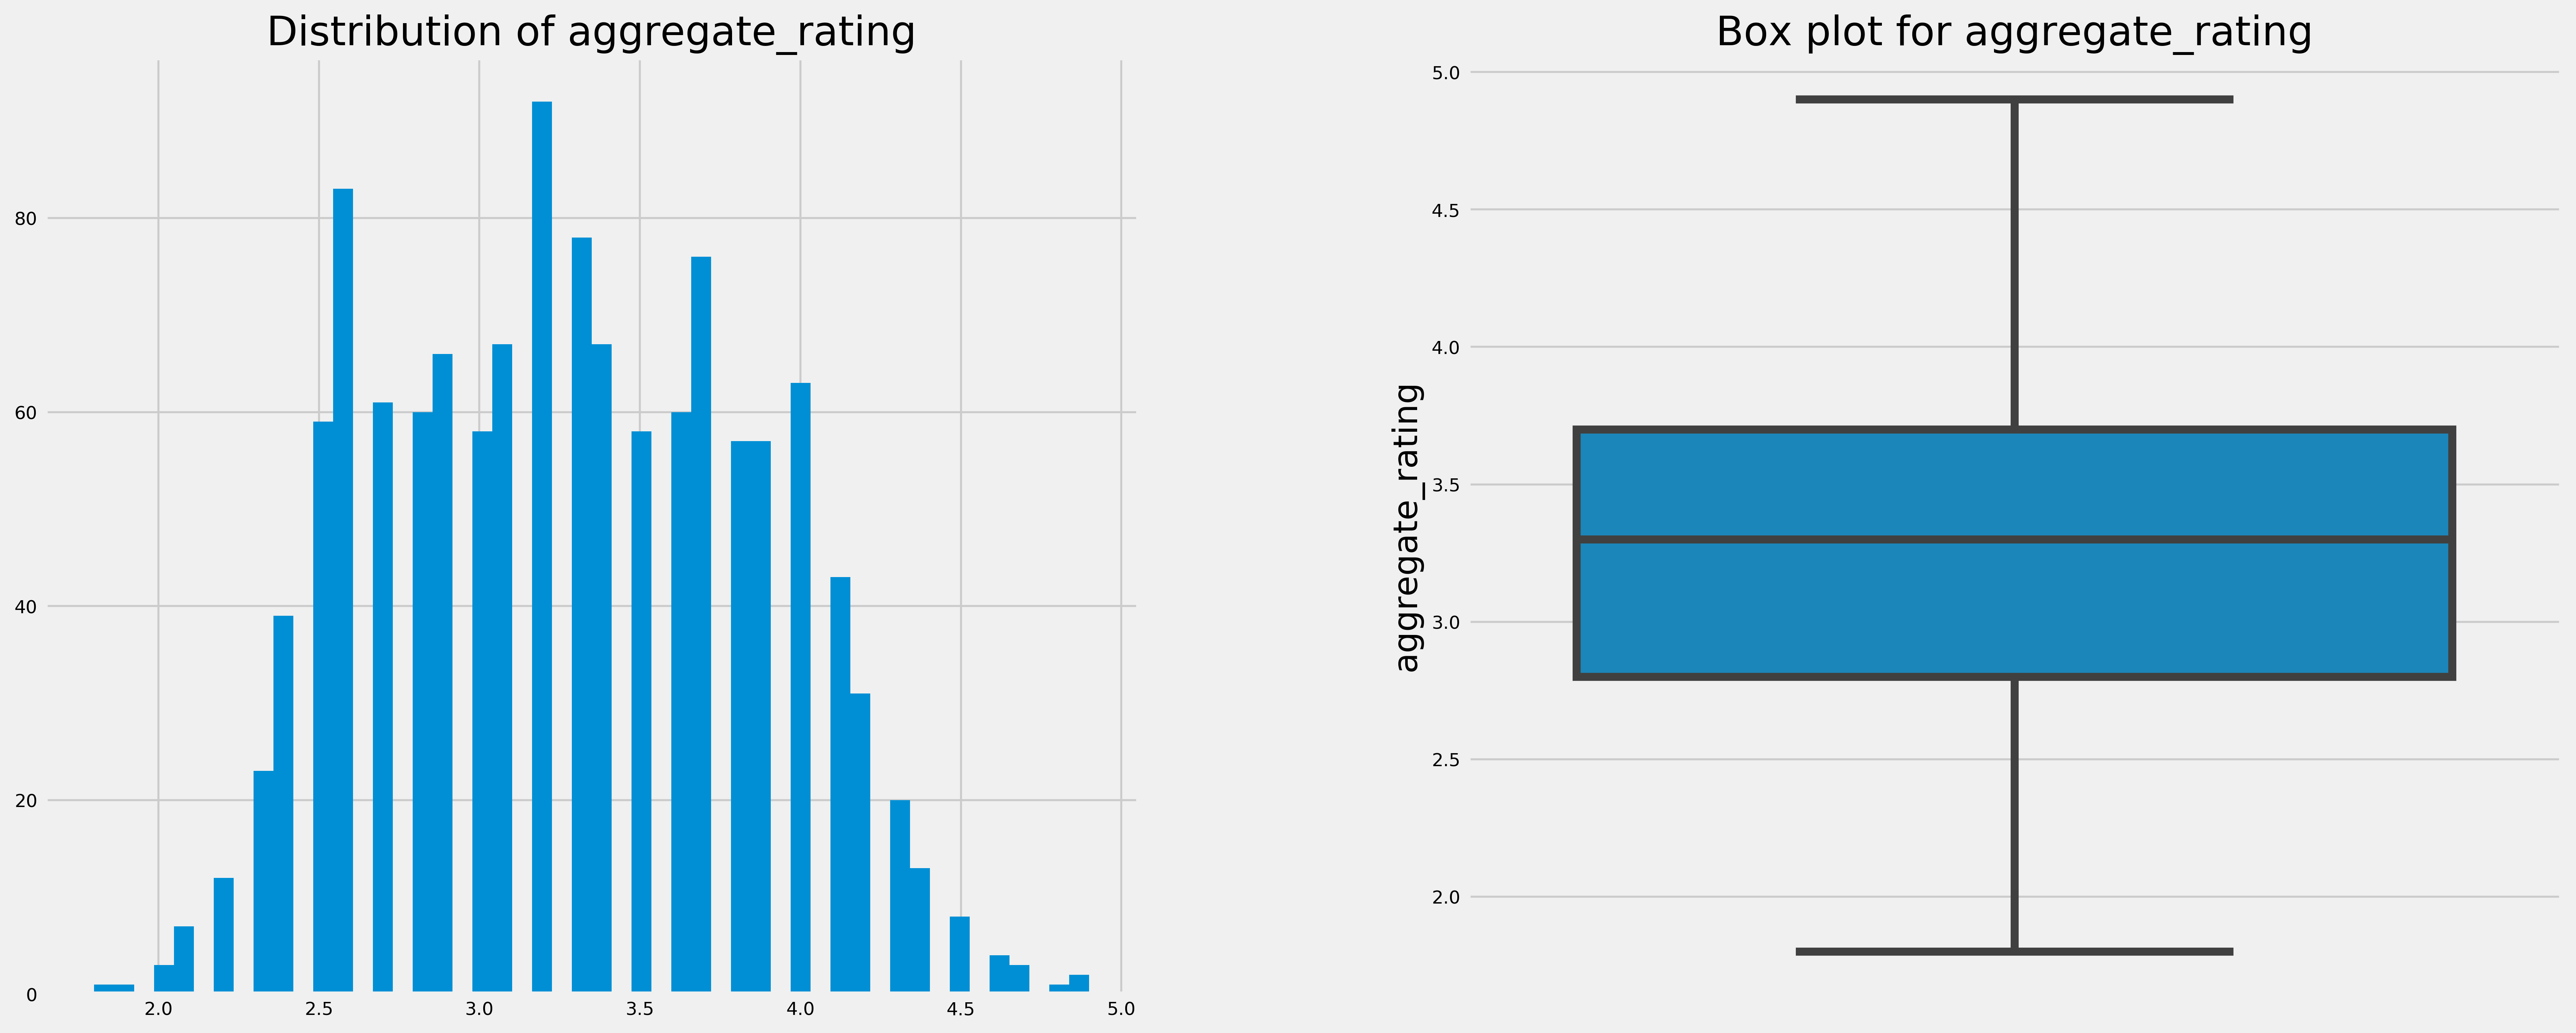

In [209]:
explore_variable(data, "aggregate_rating")

The middle 50% of ratings fall between 2.75 and 3.75 with a median of around 3.25. There are a large number of restaurants with a rating of 0. We should study these further to decide if they should be removed from the analysis or are outliers that carry useful information.

In [151]:
data[data.aggregate_rating == 0]

name  aggregate_rating  \
1273                                    Créme de Levain               0.0   
1274  Kristen's Kick Ass Ice Cream- Noordhoek Farm V...               0.0   
1275                                         Milky Lane               0.0   
1276                                             Smooch               0.0   
1277                     Daniela's Deliciously Decadent               0.0   
1278                                       Filo Yoghurt               0.0   
1279                                             Smooch               0.0   
1280                                      Ice Rock Cafe               0.0   
1281                                     Bonjour Bakery               0.0   
1282                                          Wakaberry               0.0   
1283                                         Sorbetiere               0.0   
1284                          For The Love Of Yummyness               0.0   
1285                                           The Bank               0.0   
1286                                             SoYogi               0.0   
1287                         The Polynesian Pearl Diver               0.0   
1288                           Oh La La Cocktail Lounge               0.0   
1289                                   The Chef’s Bench               0.0   
1290                            Marcel's Frozen Yoghurt               0.0   
1291                                            Mercury               0.0   
1292                                         Club Lenin               0.0   
1293                                            DV Café               0.0   
1294                                      Ice Rock Cafe               0.0   
1295                                           Yogi Bar               0.0   
1296                                           IceDream               0.0   
1297                                             Gelato               0.0   
1298                                     Caldo & Freddo               0.0   
1299                            Marcel's Frozen Yoghurt               0.0   
1300                            Marcel's Frozen Yoghurt               0.0   
1301                            Lili's Ice Cream Parlor               0.0   
1302                                   Club Eighty-Nine               0.0   
...                                                 ...               ...   
1324                                     Burger De Vine               0.0   
1325                                            The Hub               0.0   
1326                                            Wing It               0.0   
1327                                  Eezi Street Pizza               0.0   
1328                                               Sno.               0.0   
1329                                       Healthy Bite               0.0   
1330                       The Biggest Little Beer Shop               0.0   
1331                                Daytona Pub & Venue               0.0   
1332                            Sea Street Bar & Lounge               0.0   
1333                                            GoldBar               0.0   
1334                                            Sky Bar               0.0   
1335                                  Cloof Wine Estate               0.0   
1336                                               Njam               0.0   
1337                                  Fria's Superfoods               0.0   
1338                                         The Pantry               0.0   
1339                                            localli               0.0   
1340                       Sweet Cillie's Cakery & Deli               0.0   
1341                                 Oakhurst Farmstall               0.0   
1342                               At the Village Stall               0.0   
1343                         Everyway Coffee - V&A Mall               0.0   
1344                                      Craft

In [152]:
data[data.aggregate_rating == 0]["locality"].value_counts()

Kenilworth                13
CBD                        9
V & A Waterfront           5
Sea Point                  4
Stellenbosch               3
Woodstock                  3
Hermanus                   3
Goodwood                   3
Table View                 2
Brackenfell                2
Hout Bay                   2
Noordhoek                  2
Zonnebloem                 2
Bellville                  2
Somerset West              2
Neelsie Student Centre     1
De Waterkant               1
Franschhoek                1
Malmesbury                 1
Tokai                      1
Century City               1
Crawford                   1
Constantia                 1
Parklands                  1
Observatory                1
Simon's Town               1
Worcester                  1
Darling                    1
Plumstead                  1
Green Point                1
Strand                     1
Bergvliet                  1
Foreshore                  1
Paarl                      1
Diep River    

In [153]:
data[data.locality == "Kenilworth"].shape

(37, 89)

Restaurants with very few votes are given a rating of 0. Interestingly, the suburb of Kenilworth has no ratings for 13 of its 37 restaurants.

Let's see how many votes are needed before a rating is registered.

In [154]:
data[(data.aggregate_rating > 0.0) & (data.aggregate_rating < 2)] 

name  aggregate_rating rating_text  votes  average_cost_for_two  \
1271  Mugg & Bean               1.9        Poor     80                   350   
1272         Dros               1.8        Poor     78                   350   

      price_range                                      cuisines  \
1271            4                                          Cafe   
1272            4  South African, Grill, Seafood, Burger, Pizza   

      cuisine_count           places                         locality  \
1271              1             None  Cape Town International Airport   
1272              5  Canal Walk Mall                     Century City   

             ...         cuisine_Steak cuisine_Street Food  cuisine_Sushi  \
1271         ...                     0                   0              0   
1272         ...                     0                   0              0   

      cuisine_Tapas  cuisine_Tea  cuisine_Tex-Mex  cuisine_Thai  \
1271              0            0                0             0   
1272              0            0                0             0   

      cuisine_Turkish  cuisine_Vegetarian  cuisine_Vietnamese  
1271                0                   0                   0  
1272                0                   0                   0  

[2 rows x 89 columns]

There are no restaurants with a rating of 1 or less. This could just be our sample or it could be the way the rating system works. It is unclear how the ratings are assigned but some research suggests that it's weighted based on the influence carried by those who give the rating, i.e. votes from user's with a larger following are more heavily weighted. 

Should we exclude restaurants with a zero rating from the analysis? A restaurant with no rating doesn't neccessarily mean it's terrible. Fast food franchises for example are unlikely to get as many people interested in voting for them as fine-dining establishments. Also, foodie influencers are more likely to review and vote on top restaurant than on everyday fast food joints. Restaurant with 0 rating still provide us good info about the type of food in offer in a specific area, but caution must be applied when performing aggegations. It will be considered on a case-by-case basis whether it makes sense for zero-rated restaurants to be kept or removed from analysis.

'average_cost_for_two' is of type int64 with 0 missing values


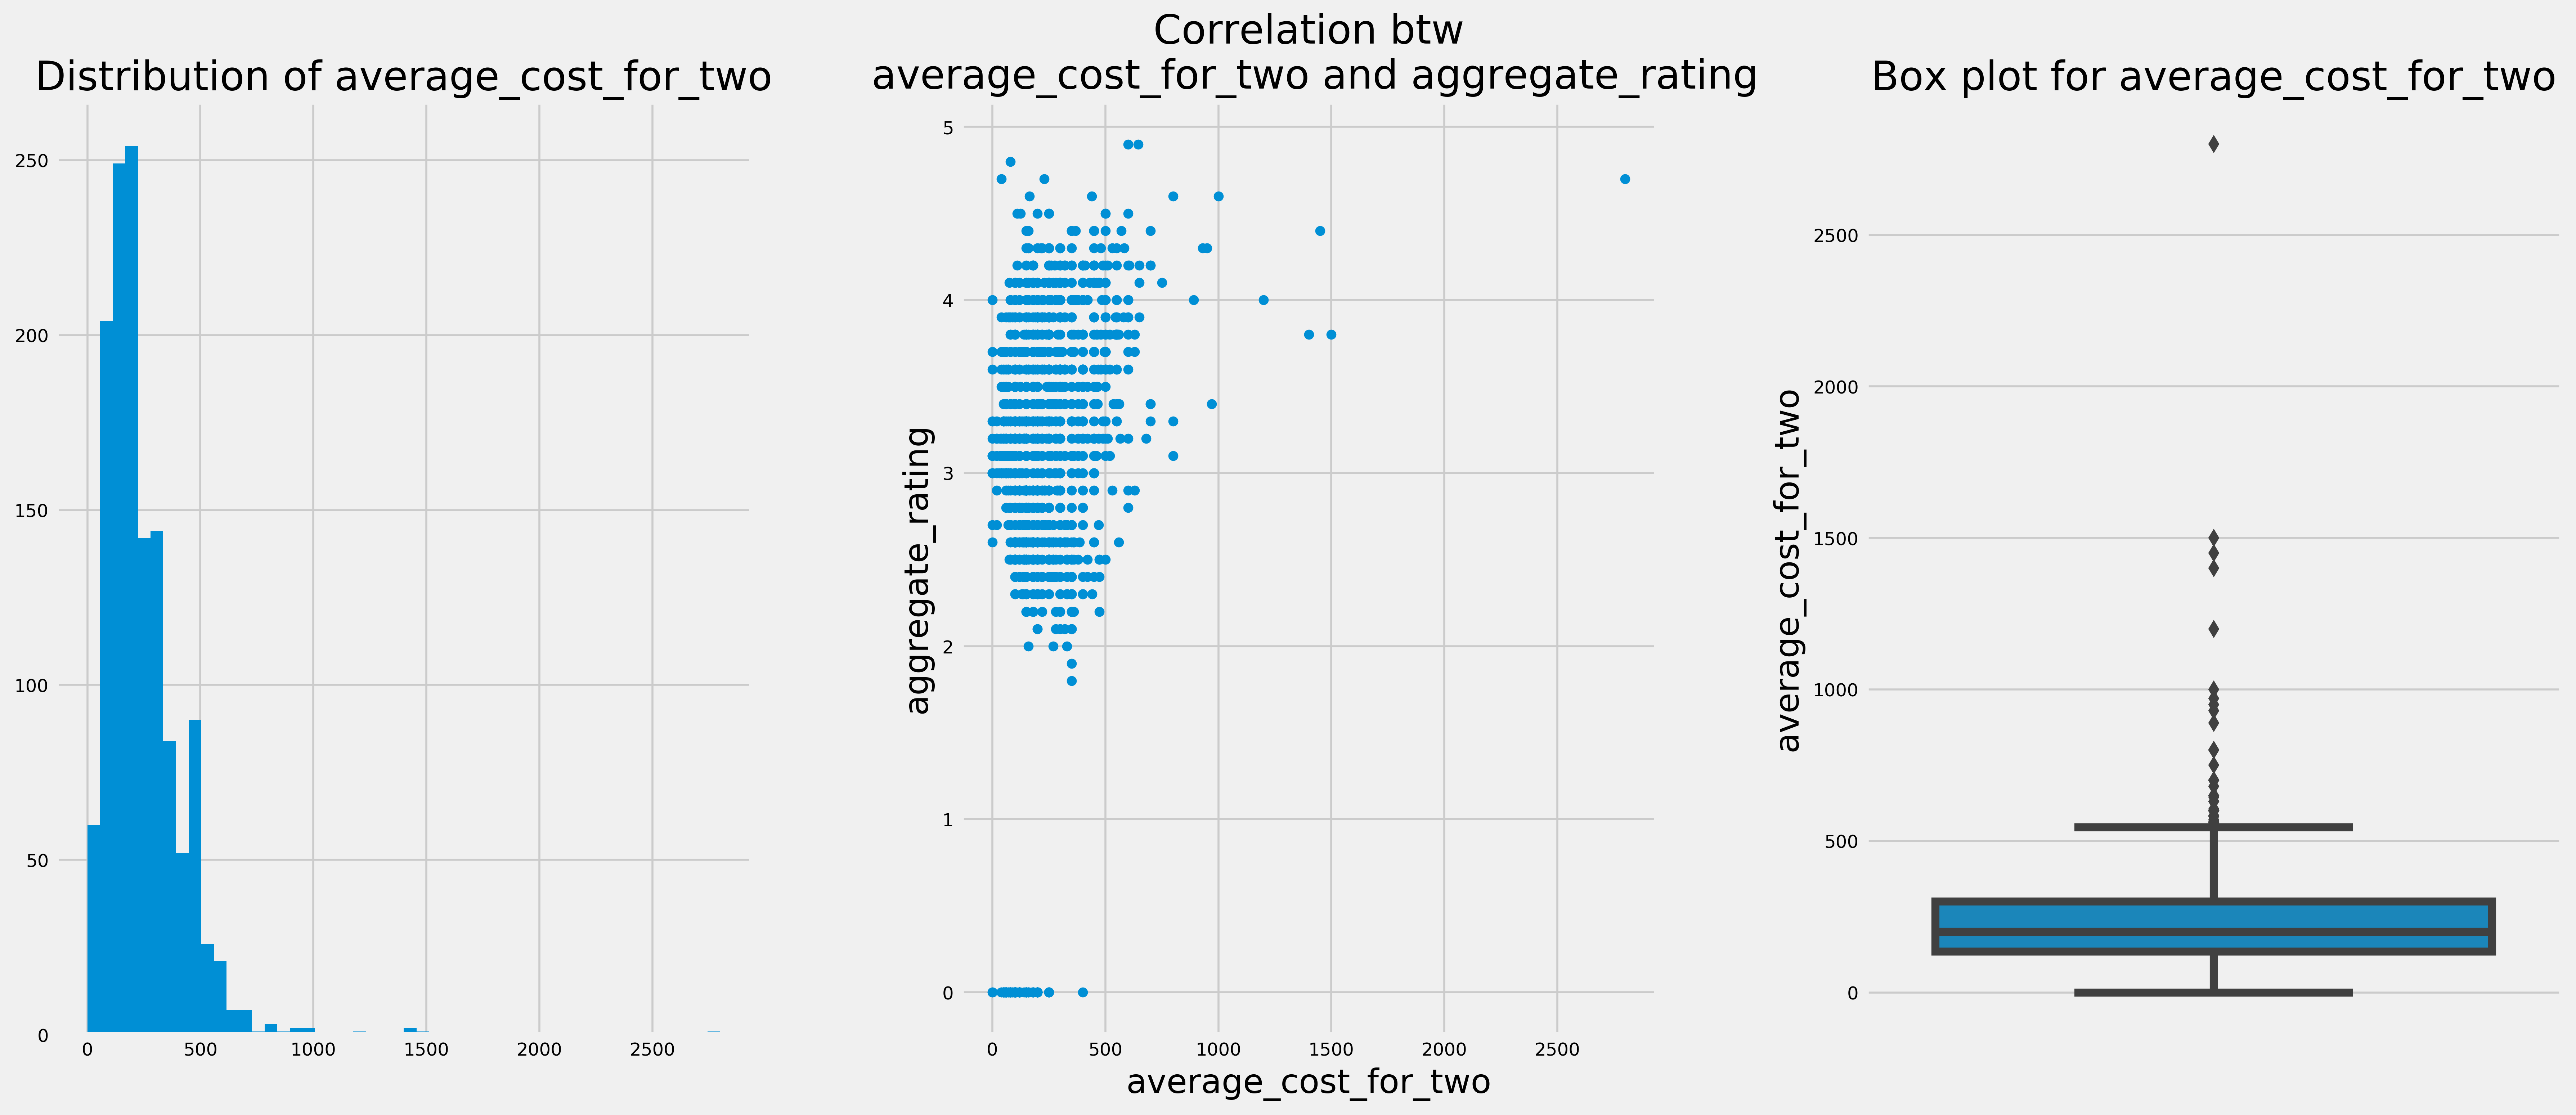

In [155]:
explore_variable(data, "average_cost_for_two", "aggregate_rating")

There isn't much correlation between avg price for two and rating. There are quite a few cost outliers but given that there are many fine-dining restaurants in Cape Town, this shouldn't be a suprise. Let's take a look at some of these.

In [156]:
data[data.average_cost_for_two > 1000]

name  aggregate_rating rating_text  votes  \
4                     The Test Kitchen               4.7   Excellent    242   
30   Greenhouse - The Cellars Hohenort               4.4   Very Good     83   
141                      Rust en Vrede               4.0   Very Good     50   
263               Reverie Social Table               3.8        Good     24   
273                     The Roundhouse               3.8        Good     68   

     average_cost_for_two  price_range  \
4                    2800            4   
30                   1450            4   
141                  1200            4   
263                  1400            4   
273                  1500            4   

                                       cuisines  cuisine_count  \
4                         Continental, European              2   
30                                     European              1   
141                                     African              1   
263  South African, International, Contemporary              3   
273                           European, African              2   

                    places      locality         ...         cuisine_Steak  \
4         Old Biscuit Mill     Woodstock         ...                     0   
30   The Cellars-Hohenhort    Constantia         ...                     0   
141                   None  Stellenbosch         ...                     0   
263                   None   Observatory         ...                     0   
273                   None     Camps Bay         ...                     0   

    cuisine_Street Food  cuisine_Sushi  cuisine_Tapas  cuisine_Tea  \
4                     0              0              0            0   
30                    0              0              0            0   
141                   0              0              0            0   
263                   0              0              0            0   
273                   0              0              0            0   

     cuisine_Tex-Mex  cuisine_Thai  cuisine_Turkish  cuisine_Vegetarian  \
4                  0             0                0                   0   
30                 0             0                0                   0   
141                0             0                0                   0   
263                0             0                0                   0   
273                0             0                0                   0   

     cuisine_Vietnamese  
4                     0  
30                    0  
141                   0  
263                   0  
273                   0  

[5 rows x 89 columns]

As expected, these are well-known top end restaurants in Cape Town. Their values may skew the mean so we should be cautious when including them in any analysis. Let's see if the top end restaurants (in terms of avg. cost) tend to come from certain suburbs.

In [157]:
data[data.average_cost_for_two >= 800]["locality"].value_counts()

Constantia          3
Paarl               2
V & A Waterfront    2
Hermanus            1
Woodstock           1
Stellenbosch        1
Observatory         1
Gardens             1
Camps Bay           1
Name: locality, dtype: int64

Let's get a sense of how the restaurants on the low end of pricing are distributed geographically.

In [158]:
data[data.average_cost_for_two <= 200]["locality"].value_counts()

CBD                                72
Stellenbosch                       62
V & A Waterfront                   38
Sea Point                          36
Bellville                          30
Claremont                          29
Kenilworth                         28
Century City                       24
Durbanville                        22
Franschhoek                        20
Table View                         19
Gardens                            18
Somerset West                      17
Observatory                        16
Paarl                              16
Green Point                        16
Woodstock                          15
Brackenfell                        15
Rondebosch                         14
De Waterkant                       14
Goodwood                           12
Hermanus                           11
Hout Bay                           11
Newlands                            9
Parklands                           8
Constantia                          8
Foreshore   

There are also many establishments that define themselves as `Drinks Only` - bars, cocktail lounges etc. We might want to create a sepersate dataset for these and/or exclude them from analysis in some instances. 

In [159]:
data[data["cuisines"] == "Drinks Only"]

name  aggregate_rating  \
44                                         The Gin Bar               4.3   
97                               Fairview Tasting Room               4.1   
120                                         Boschendal               4.1   
180                             Steenberg Tasting Room               4.0   
181                              Waterford Wine Estate               4.0   
201                            Groot Constantia Winery               3.9   
223                      Tasting Room at Babylonstoren               3.9   
225                             Vergenoegd Wine Estate               3.9   
237                           Spice Route Tasting Room               3.9   
240             Van Ryn's Distillery and Brandy cellar               3.9   
248                          Rupert & Rothschild Wines               3.8   
310                                     Arra Vineyards               3.7   
325                                 Spier Wine Tasting               3.7   
331                               Vrede en Lust Winery               3.7   
364                                            Cabrito               3.7   
371                            Mother's Ruin - Gin Bar               3.7   
372                                  Peter Falke Wines               3.7   
376                                   The Silo Rooftop               3.7   
396                              Rickety Bridge Winery               3.6   
397                            Lourensford Wine Estate               3.6   
432                                    Ernie Els Wines               3.6   
448                               Delheim Tasting Room               3.5   
465                               Cavalli Tasting Room               3.5   
466                          Delaire Graff Wine Lounge               3.5   
468                          Altydgedacht Tasting Room               3.5   
470                                         Deco Dance               3.5   
506   Anthonij Rupert Tasting Room @ L'Ormarins Estate               3.4   
507                             Hillcrest Tasting Room               3.4   
531                           Van Loveren Tasting Room               3.4   
544                        Harringtons Cocktail Lounge               3.4   
...                                                ...               ...   
961                                      Pig & Swizzle               2.8   
963                                           Bang Bar               2.8   
971                                     Hanover Street               2.8   
972                                           Crew Bar               2.8   
976                                 Banned Rock Lounge               2.8   
978                               Newton Johnson Wines               2.8   
979                                        Casa Nostra               2.8   
1013                           Two And Sixpence Tavern               2.7   
1018                                            Abantu               2.7   
1020                                       The Crowbar               2.7   
1028                                           Jo'burg               2.7   
1058                                           Zevolis               2.6   
1136                                       The Cue Inn               2.5   
1137                                            Stones               2.5   
1194                                          Tin Roof               2.4   
1285                                          The Bank               0.0   
1287                        The Polynesian Pearl Diver               0.0   
1288                          Oh La La Cocktail Lounge               0.0   
1291                                           Mercury               0.0   
1292                                        Club Lenin               0.0   
1302                                  Club Eighty-Nine               0.0   
1306                  

'price_range' is of type int64 with 0 missing values


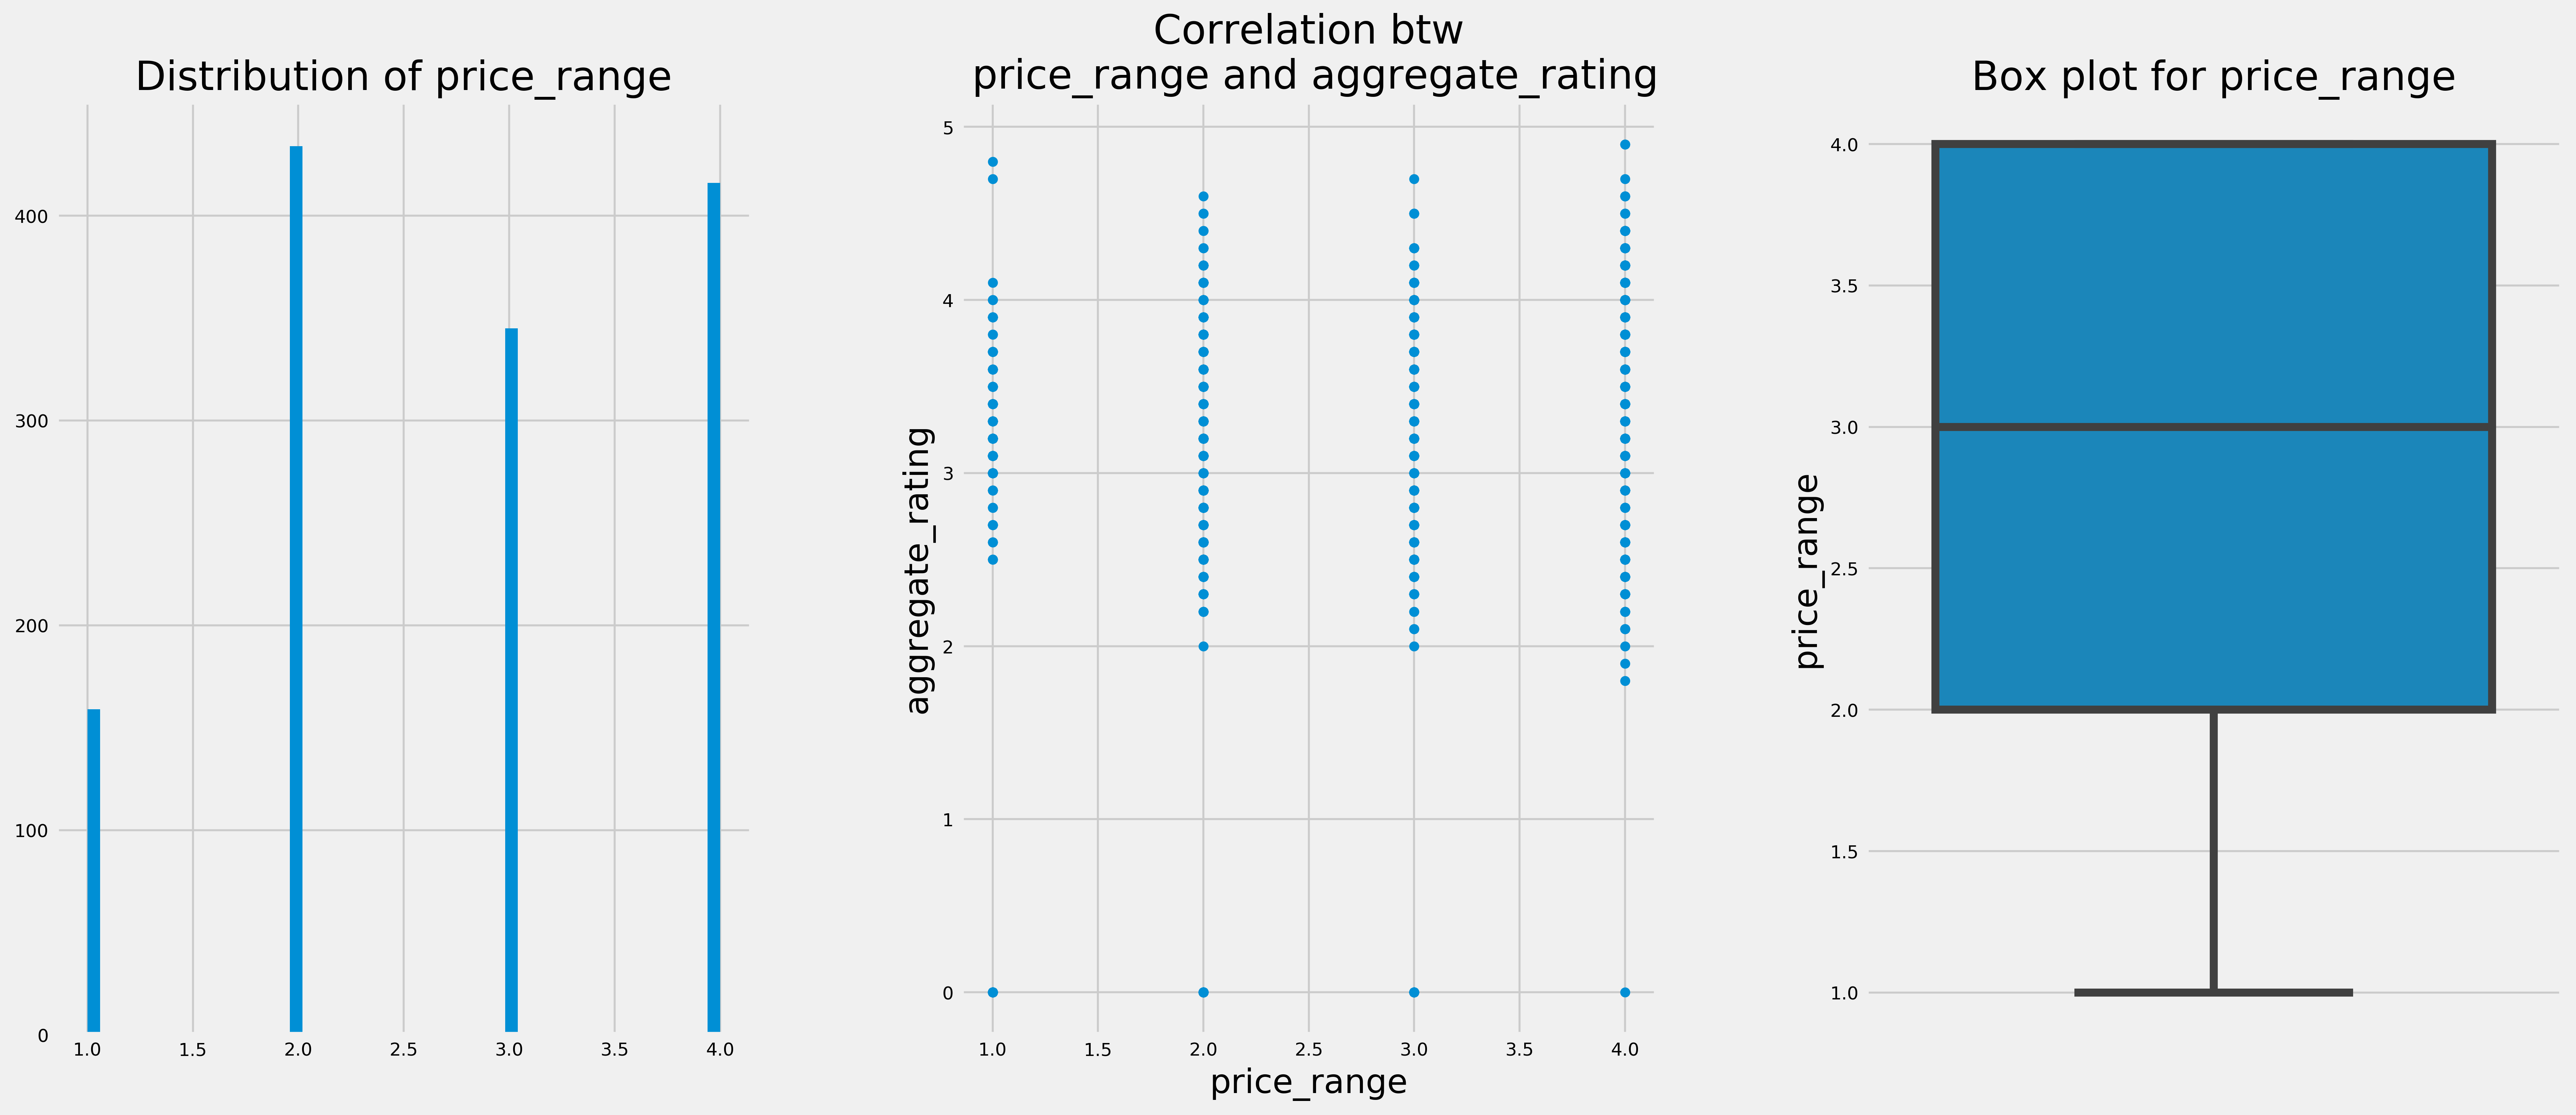

In [160]:
explore_variable(data, "price_range", "aggregate_rating")

Closely related to average price for two is the `price_range` variable assigned by Zomato. This is a 1 - 4 scale and we can see that the majority of restaurants are in price range 2 and 4. Let's see what the median cost per two is for each of those ranges. We'll look at median instead of mean as we know that some top-end restarants will skew price range 4. 

In [161]:
df = data.pivot_table(index="price_range", aggfunc="median")
df

aggregate_rating  average_cost_for_two  cuisine_African  \
price_range                                                            
1                         3.1                    60                0   
2                         2.9                   150                0   
3                         3.2                   220                0   
4                         3.6                   400                0   

             cuisine_American  cuisine_Arabian  cuisine_Asian  cuisine_BBQ  \
price_range                                                                  
1                           0                0              0            0   
2                           0                0              0            0   
3                           0                0              0            0   
4                           0                0              0            0   

             cuisine_Bakery  cuisine_Bar Food  cuisine_Belgian  ...    \
price_range                                                     ...     
1                         0                 0                0  ...     
2                         0                 0                0  ...     
3                         0                 0                0  ...     
4                         0                 0                0  ...     

             cuisine_Thai  cuisine_Turkish  cuisine_Vegetarian  \
price_range                                                      
1                       0                0                   0   
2                       0                0                   0   
3                       0                0                   0   
4                       0                0                   0   

             cuisine_Vietnamese  cuisine_count  has_online_delivery  \
price_range                                                           
1                             0              1                    0   
2                             0              1                    0   
3                             0              2                    0   
4                             0              2                    0   

             has_table_booking   latitude  longitude  votes  
price_range                                                  
1                            0 -33.919542  18.558908      7  
2                            0 -33.921902  18.470576     14  
3                            0 -33.927217  18.464828     29  
4                            0 -33.921914  18.459665     52  

[4 rows x 81 columns]

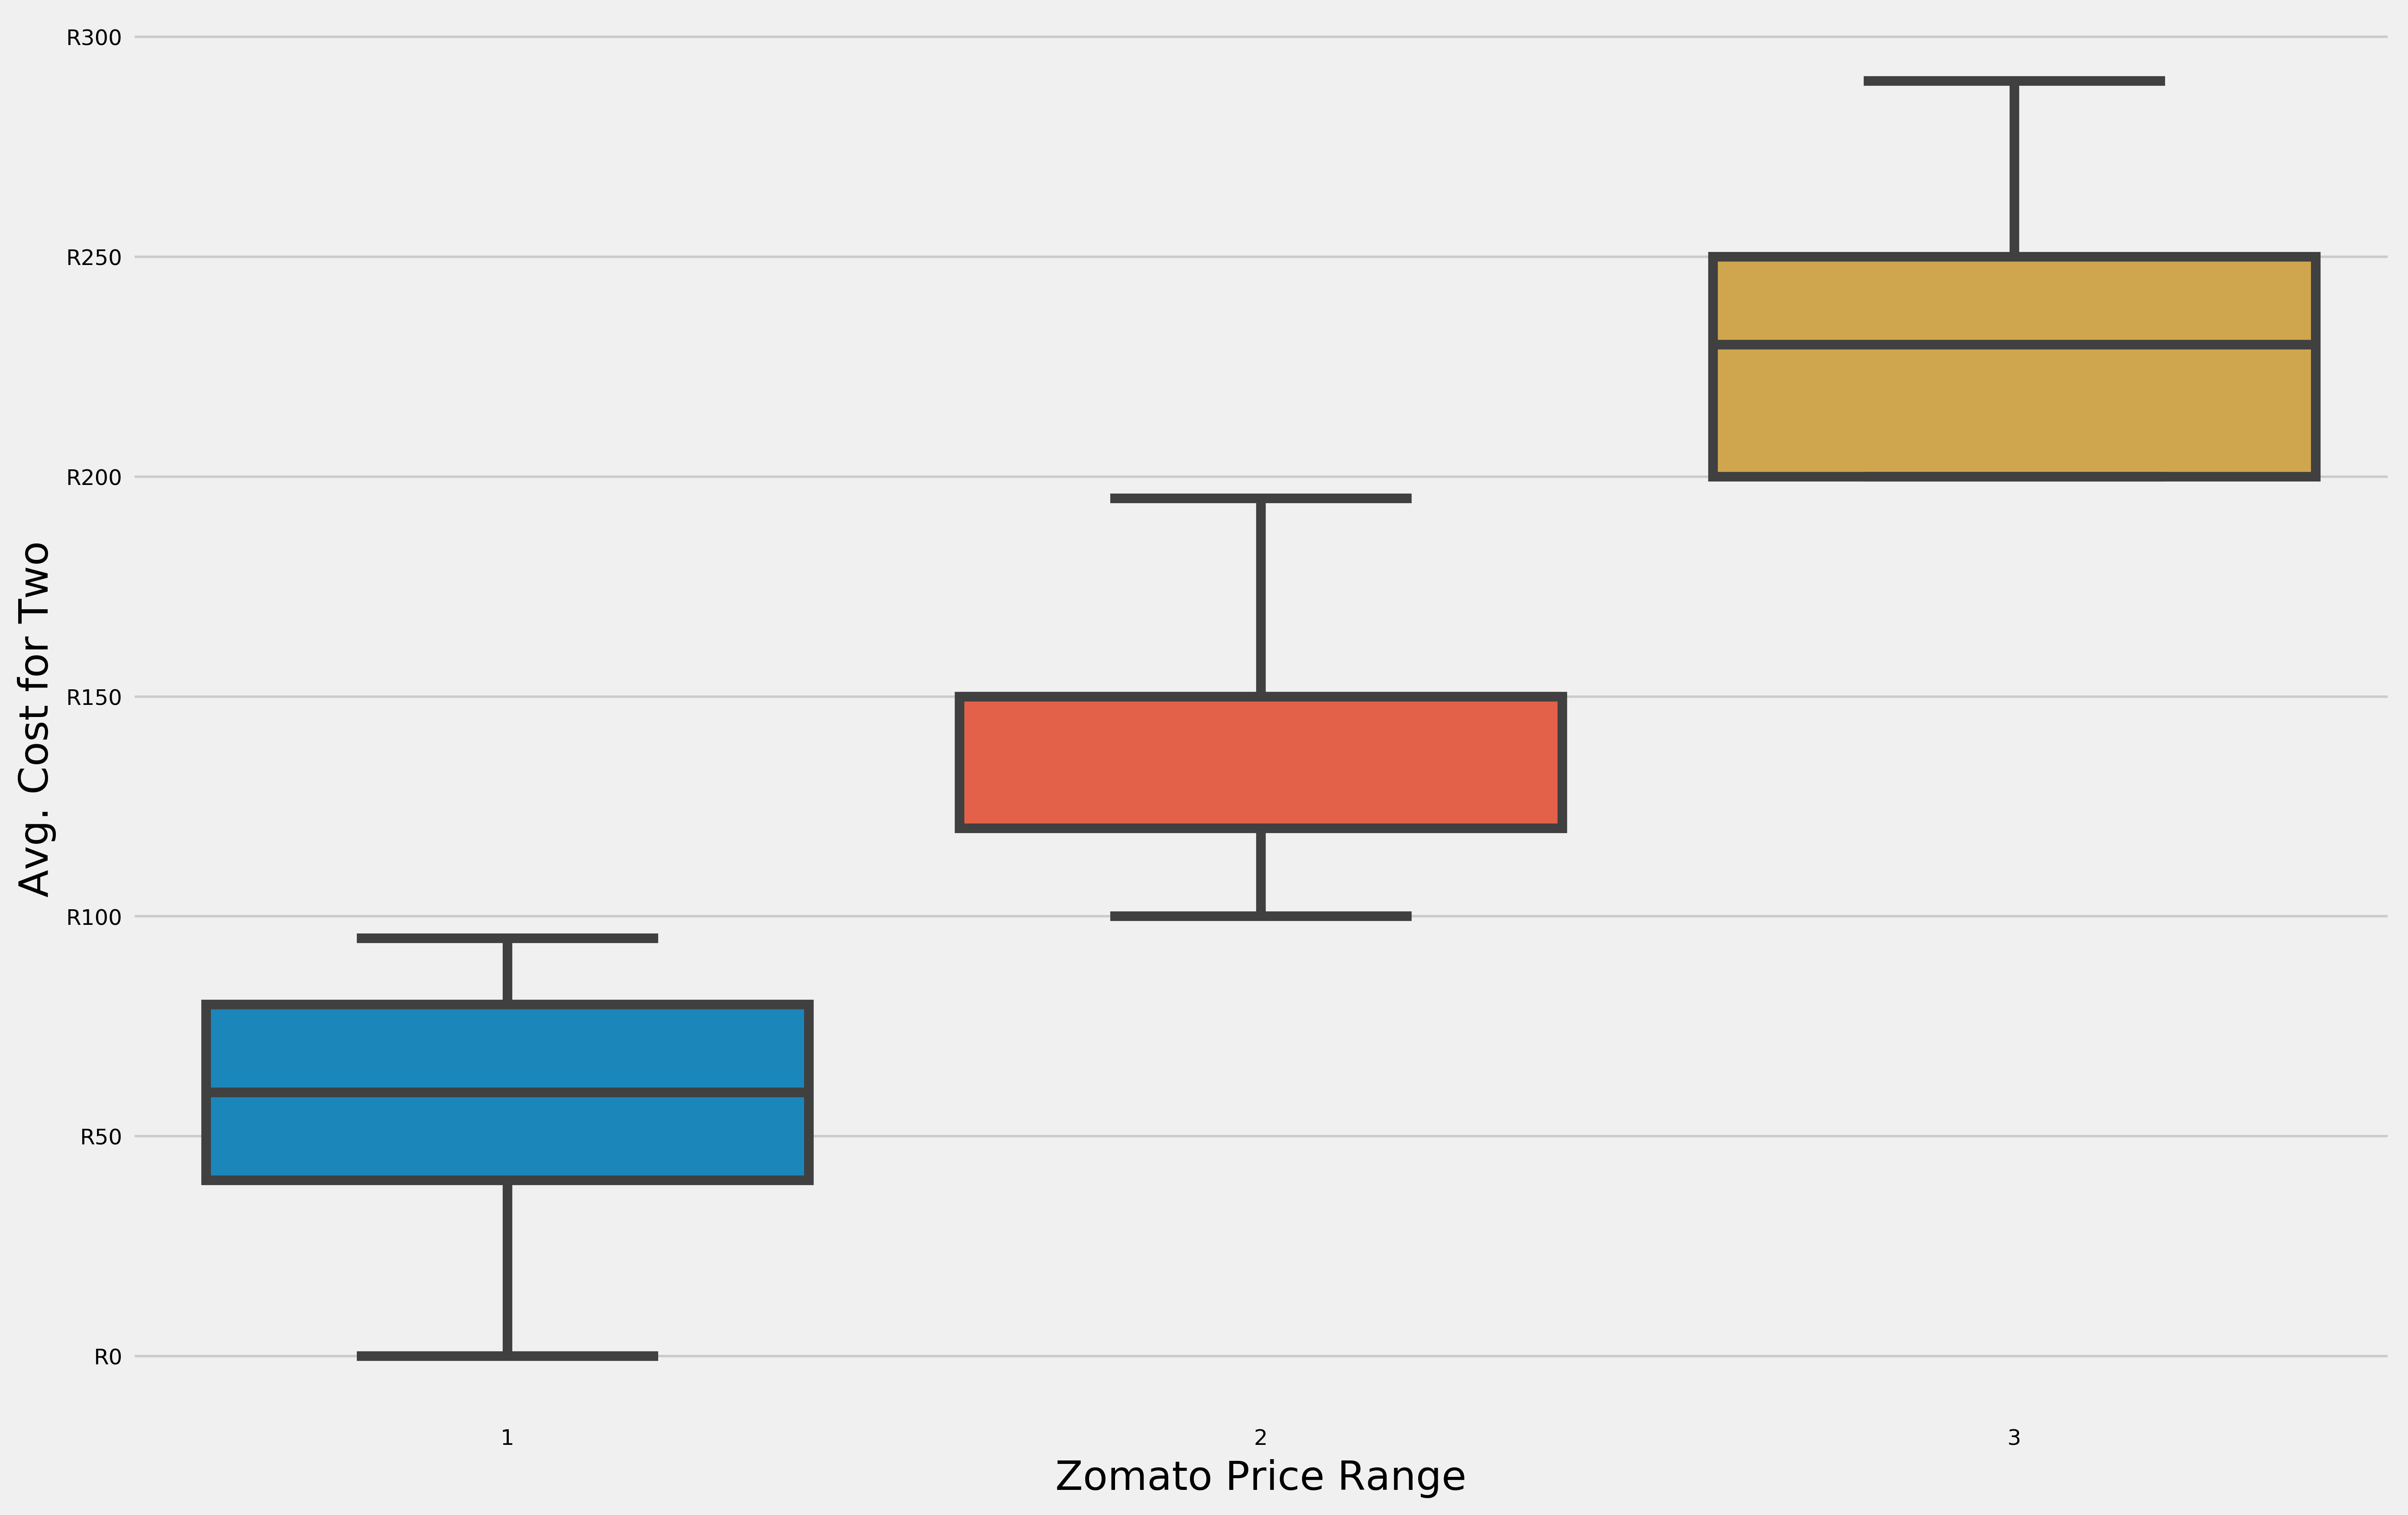

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=400)
ax = sns.boxplot(x="price_range", y="average_cost_for_two", data=data[data.price_range <= 3])
ax.set_ylabel("Avg. Cost for Two")
ax.set_xlabel("Zomato Price Range")
ax.yaxis.set_major_formatter(axes_formatter)

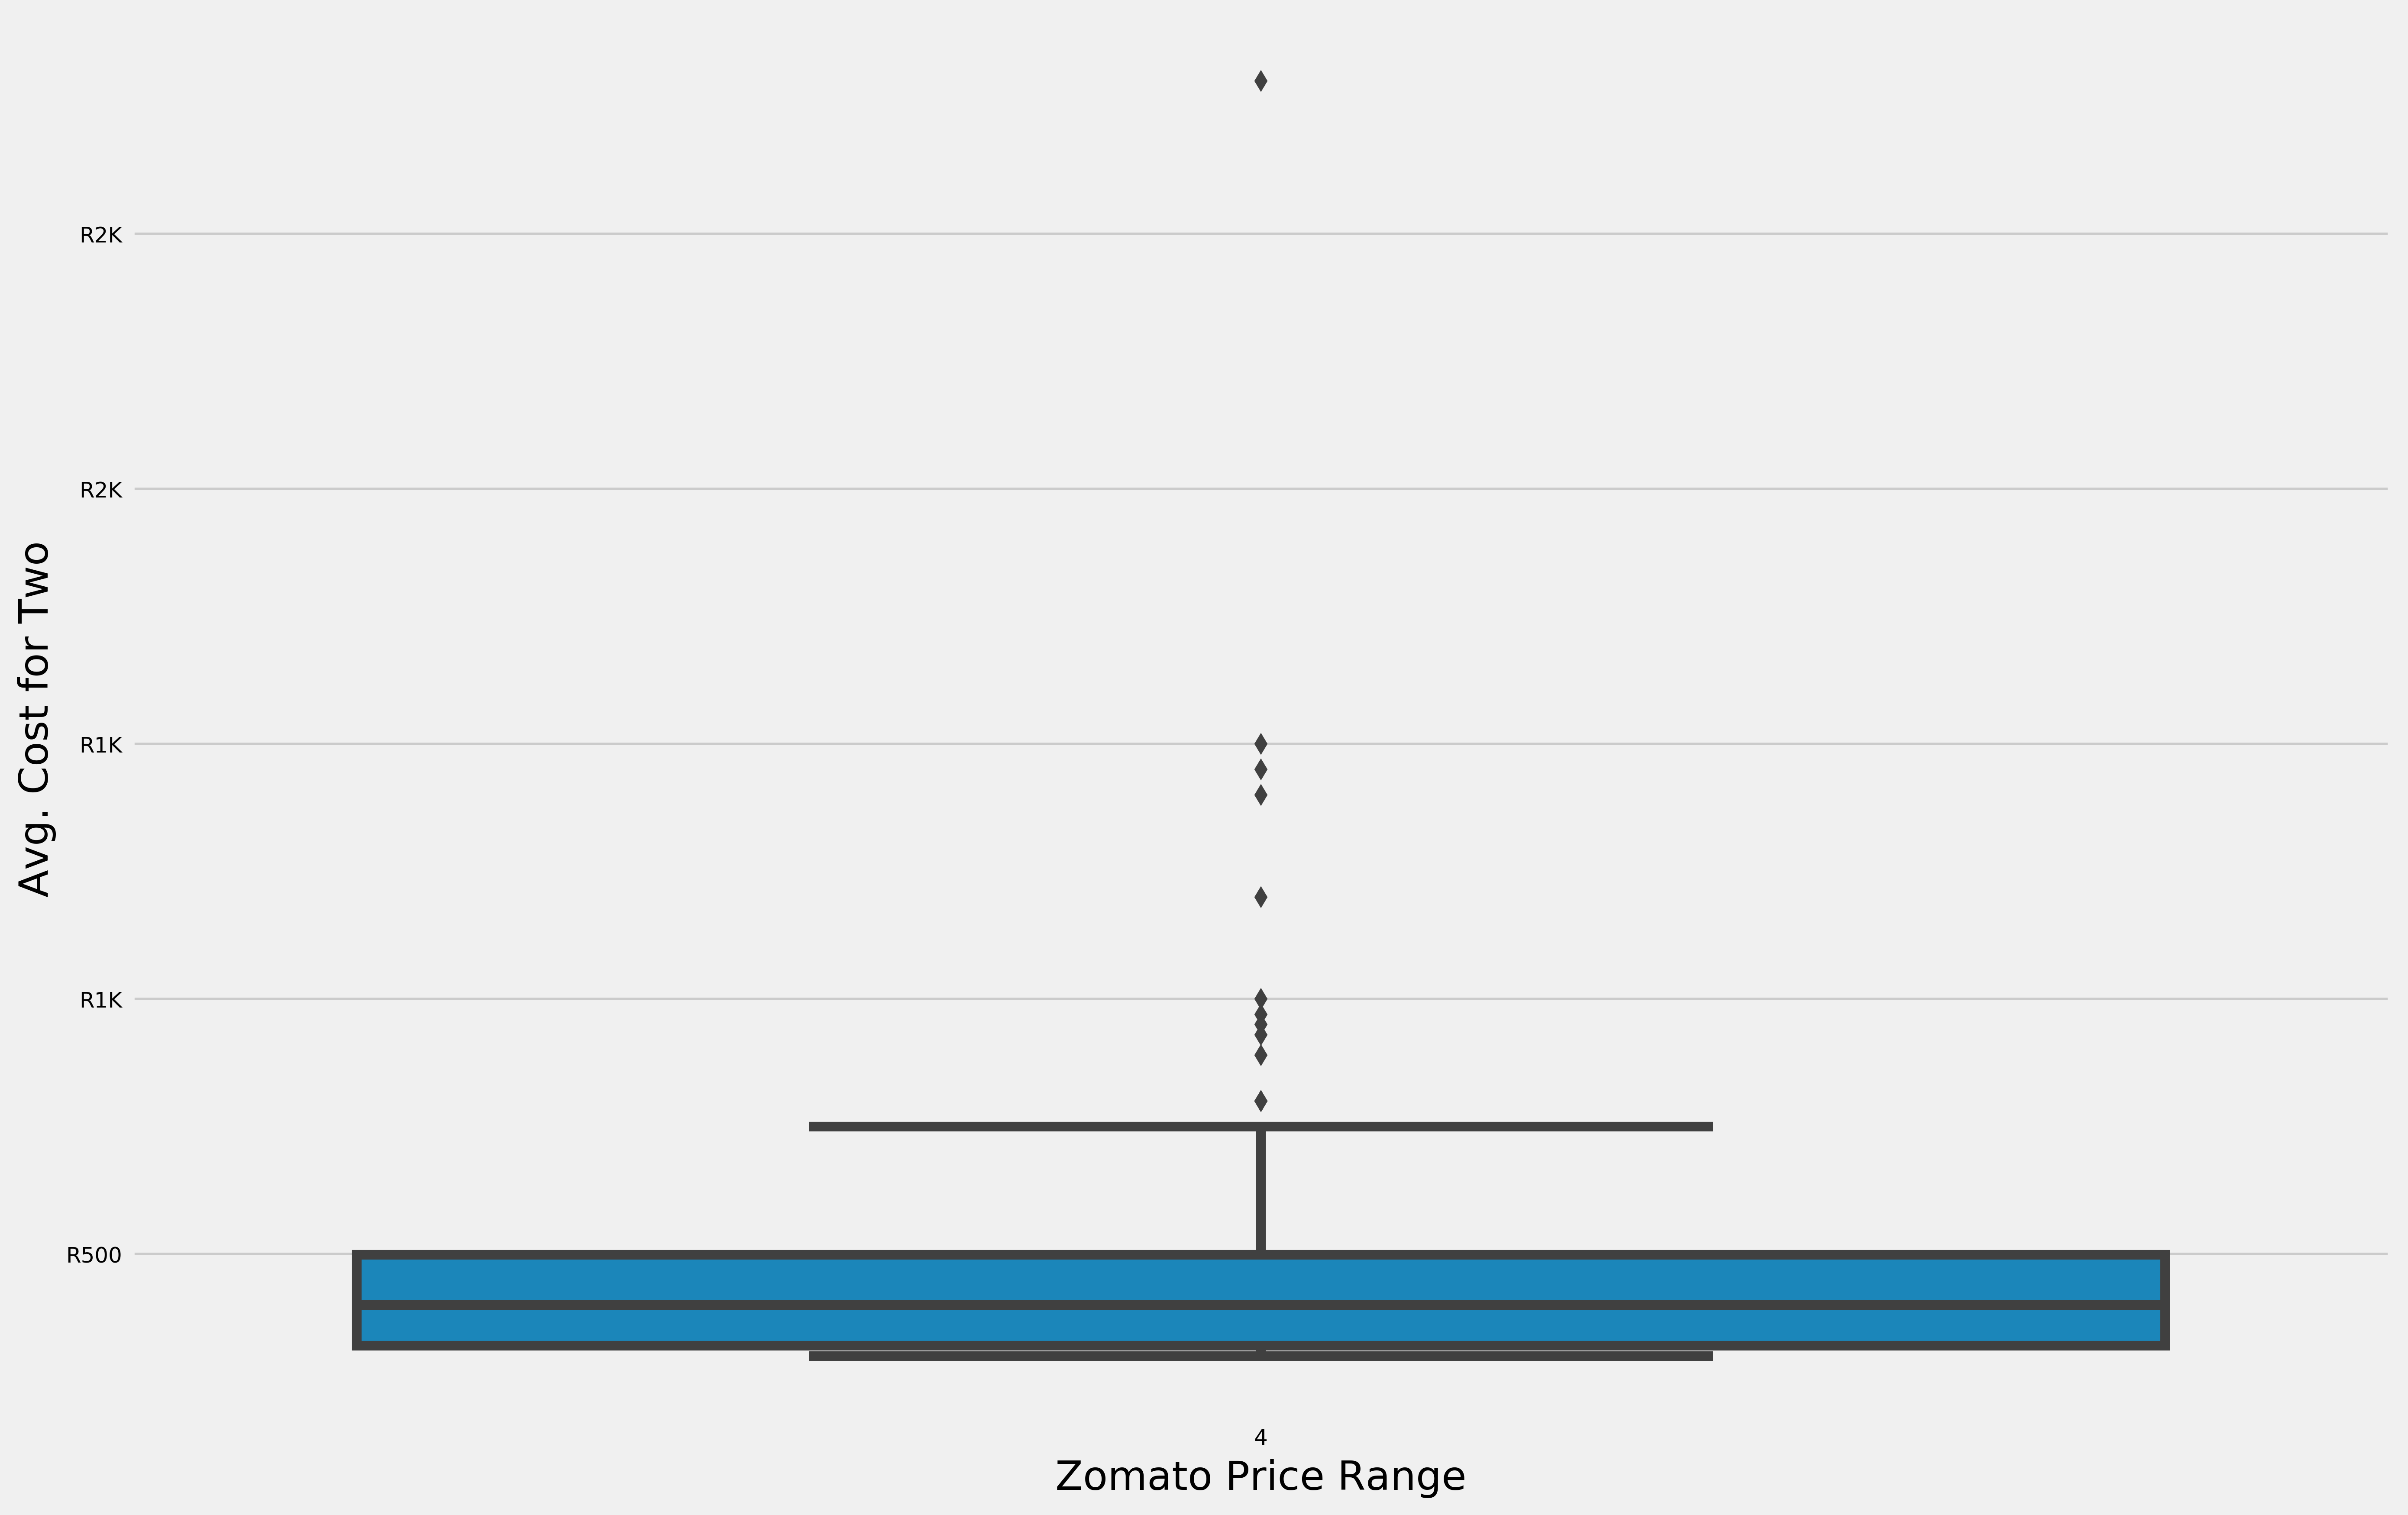

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=400)
ax = sns.boxplot(x="price_range", y="average_cost_for_two", data=data[data.price_range > 3])
ax.set_ylabel("Avg. Cost for Two")
ax.set_xlabel("Zomato Price Range")
ax.yaxis.set_major_formatter(axes_formatter)

Once again let's consider the mean values for rating, vote count and total number of cuisines on offer per price range.

Text(0.5,0.98,'Avg. Rating, Votes & No. Cuisines by Price Range')

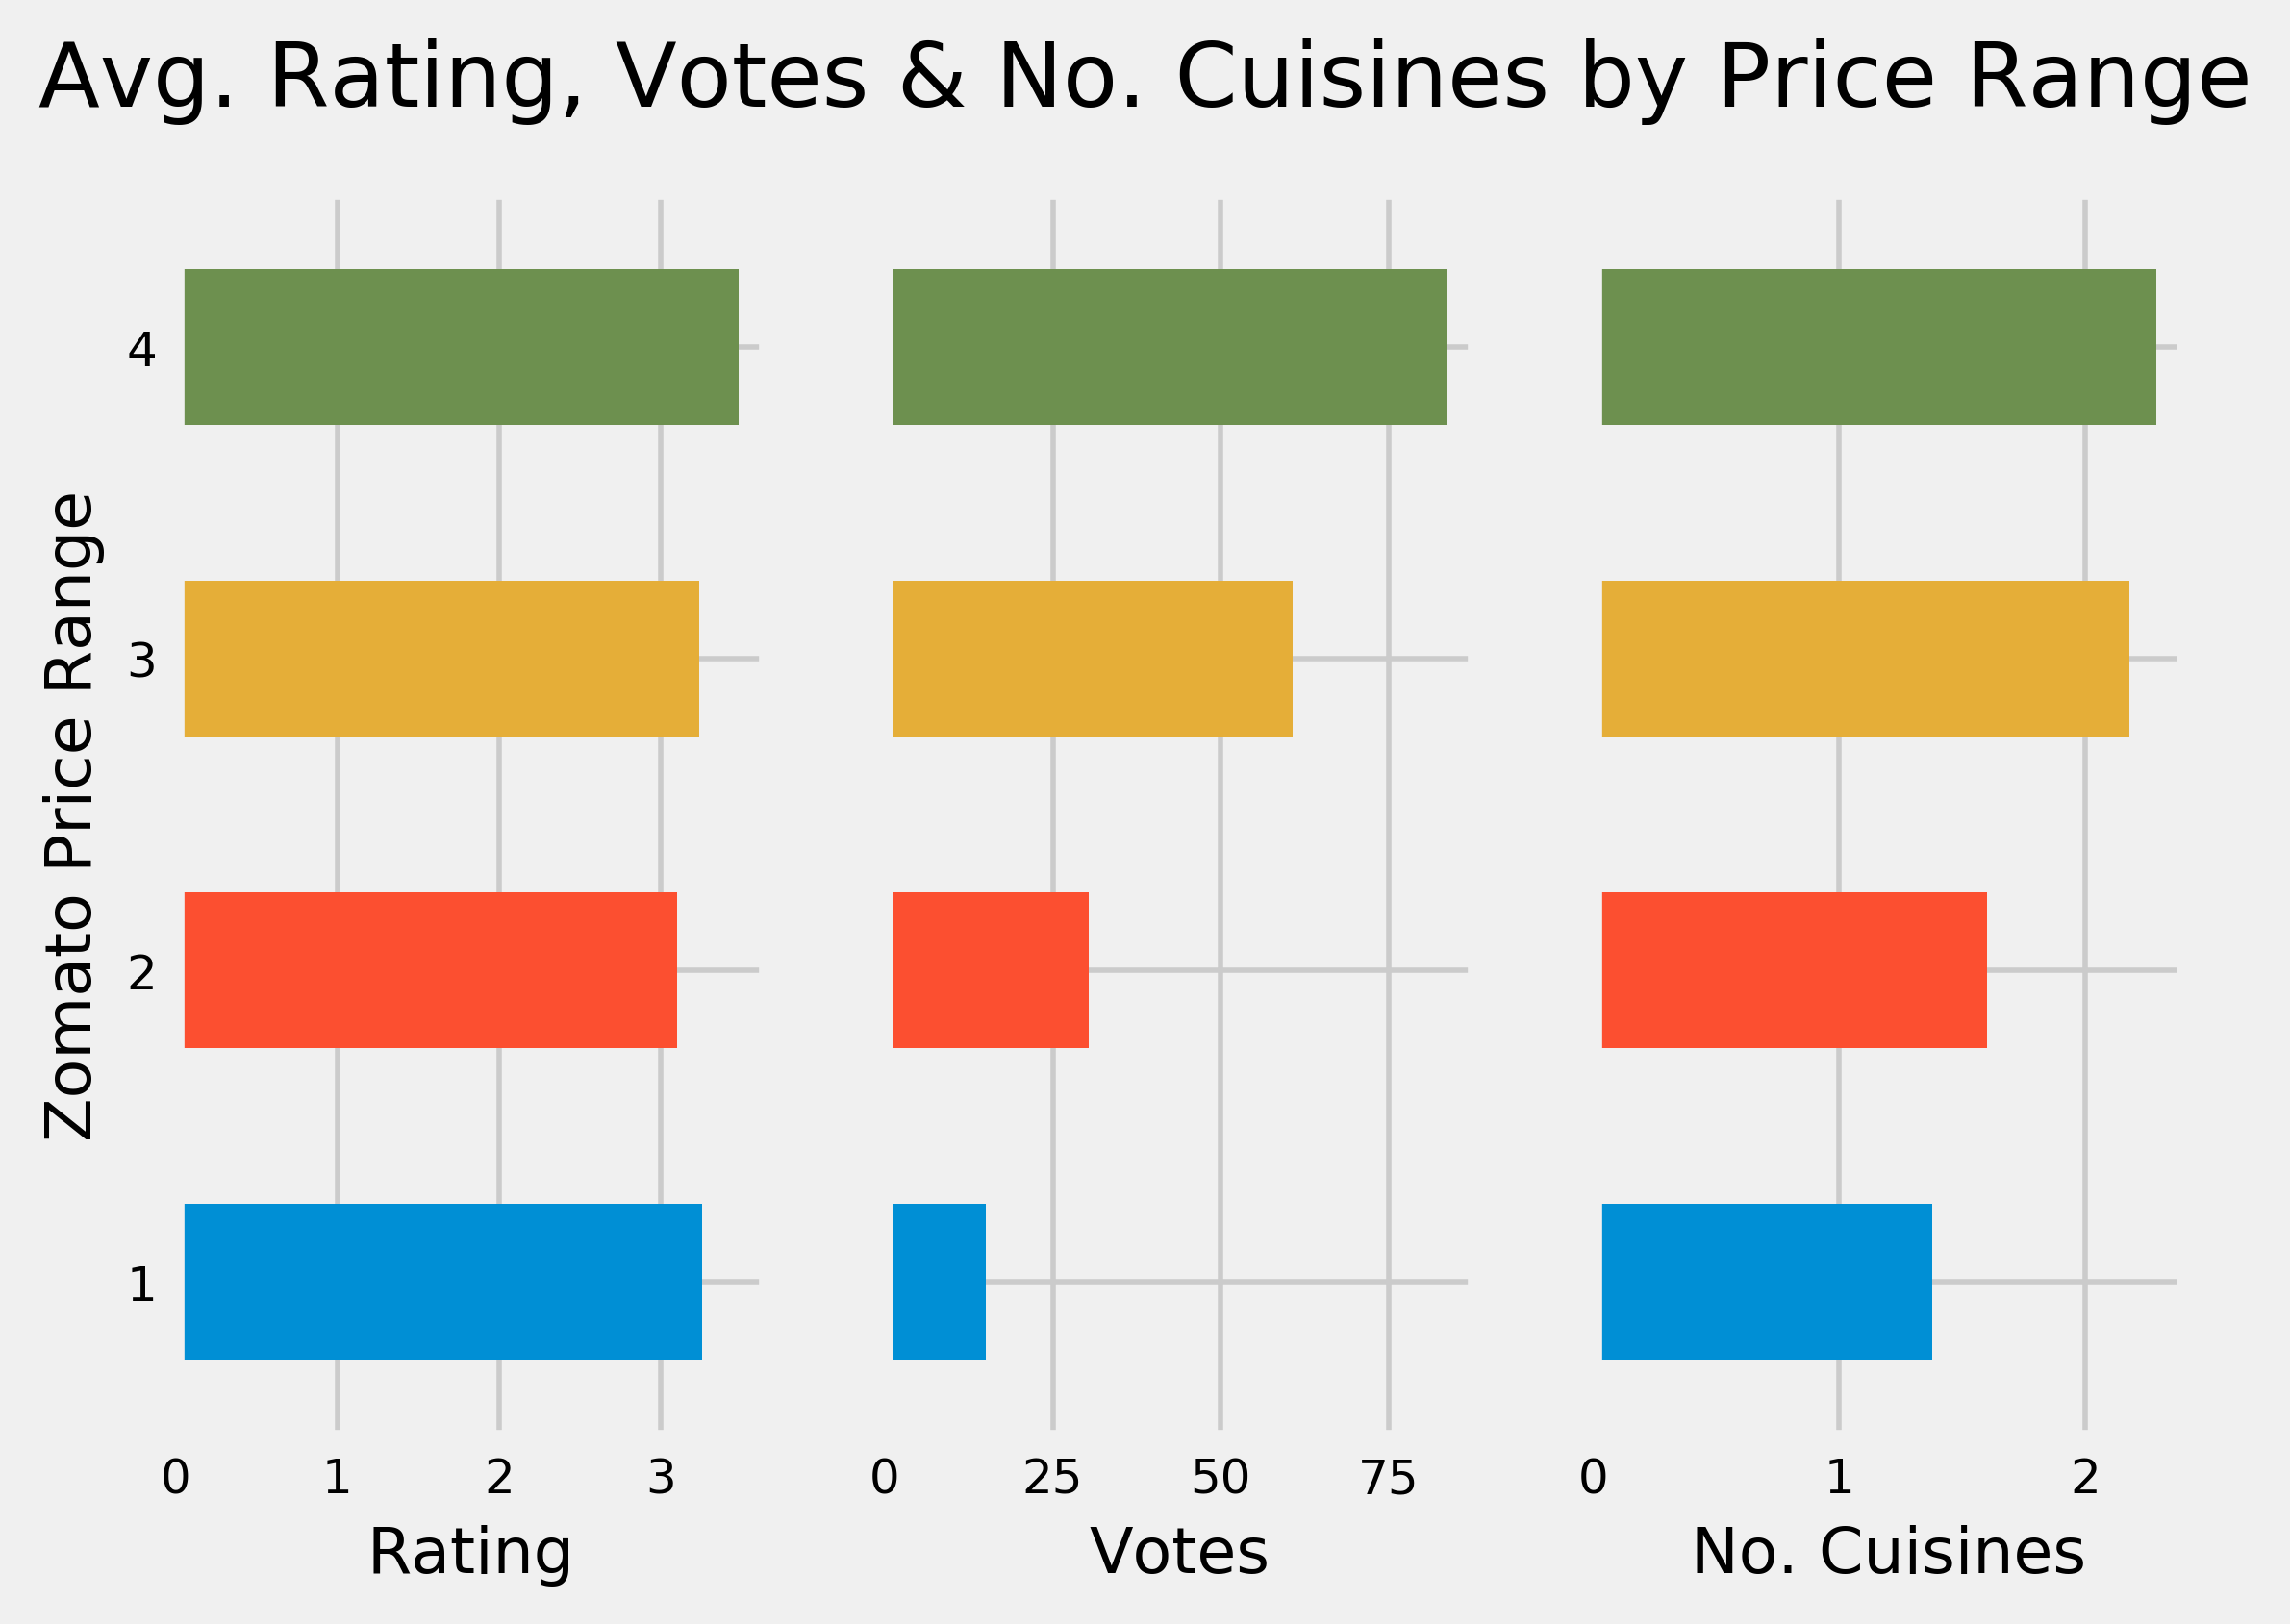

In [215]:
df = data.pivot_table(index="price_range", aggfunc="mean")

cols = ["aggregate_rating", "votes", "cuisine_count"]
xlabels = ["Rating", "Votes", "No. Cuisines"]
fig, ax = plt.subplots(1, 3, sharey='row', dpi=400)
#fig.subplots_adjust(hspace=0.4)

for ax, col, xlabel in zip(ax.ravel(), cols, xlabels):
    df[col].plot.barh(ax=ax)
    ax.set_xlabel(xlabel)
    if col == "average_cost_for_two":
        ax.xaxis.set_major_formatter(axes_formatter)
    ax.set_ylabel("Zomato Price Range")
   
plt.suptitle("Avg. Rating, Votes & No. Cuisines by Price Range")
#save_fig('investment-multiple-years-risks-lump-sum-monthly-contrib')

The lower the price range, the lower the avgerage rating and average number of votes. 

'votes' is of type int64 with 0 missing values


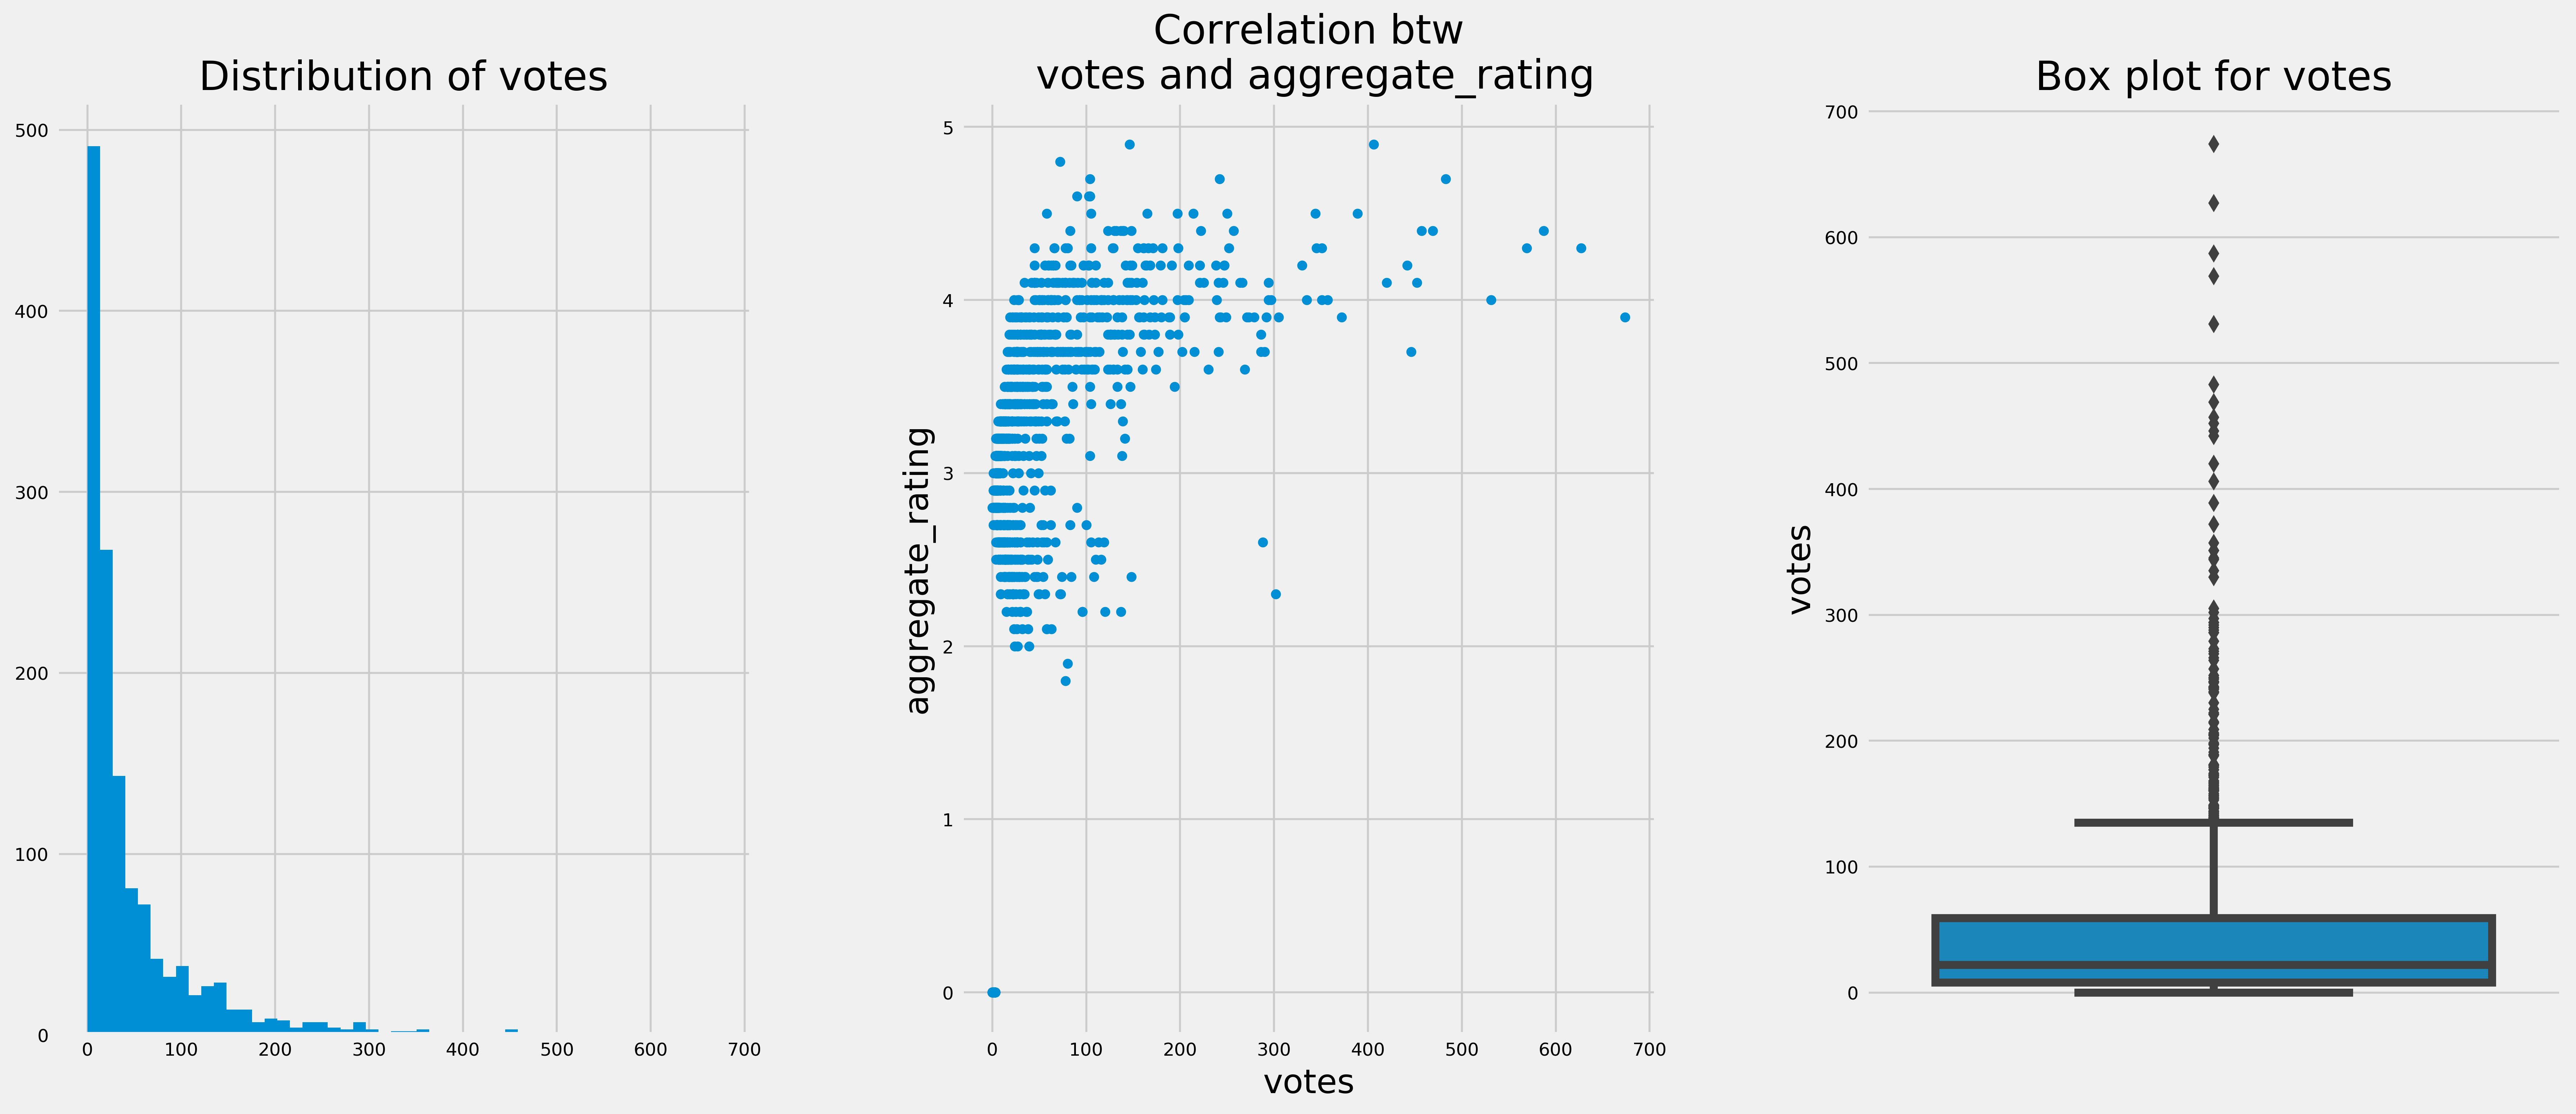

In [165]:
explore_variable(data, "votes", "aggregate_rating")

The majority of restaurnts have less than 200 votes with higher vote counts being provided for the restaurants that earn a higher rating. It's possible that people are more interested to vote on the higher-end restaurants and then due to Zomato's rating system, there is a non-linear relationship between the influence carried by those who do vote based on their community influence. 

Let's study the restaurants with the most votes.

In [166]:
data[data.votes >= 200]

name  aggregate_rating rating_text  votes  \
0                      The Potluck Club               4.9   Excellent    406   
4                      The Test Kitchen               4.7   Excellent    242   
5                               Jarryds               4.7   Excellent    483   
11                           La Mouette               4.5   Excellent    250   
12                     Bistro Sixteen82               4.5   Excellent    214   
16                         The Creamery               4.5   Excellent    389   
17                        Four & Twenty               4.5   Excellent    344   
18                   Kloof Street House               4.4   Very Good    469   
19                              Pigalle               4.4   Very Good    257   
26                             El Burro               4.4   Very Good    457   
27                     Willoughby & Co.               4.4   Very Good    587   
28                     Burger & Lobster               4.4   Very Good    222   
38                       Starlings Cafe               4.3   Very Good    351   
41                   Jerry's Burger Bar               4.3   Very Good    345   
42                        Royale Eatery               4.3   Very Good    569   
43                Honest Chocolate Cafe               4.3   Very Good    252   
45                         Truth Coffee               4.3   Very Good    627   
52                               tashas               4.2   Very Good    209   
62                              Woodies               4.2   Very Good    247   
64                             Il Leone               4.2   Very Good    247   
65                                NV 80               4.2   Very Good    221   
75                               tashas               4.2   Very Good    442   
77                         Jason Bakery               4.2   Very Good    330   
79                        Bacon on Bree               4.2   Very Good    238   
82                            La Boheme               4.1   Very Good    294   
100                  Nuri Sushi Factory               4.1   Very Good    452   
101                              tashas               4.1   Very Good    221   
102                      The Fat Cactus               4.1   Very Good    420   
104                               Bocca               4.1   Very Good    225   
106                       Cafe Paradiso               4.1   Very Good    264   
...                                 ...               ...         ...    ...   
144   IYO Burgers (Inside & You're Out)               4.0   Very Good    351   
145                             Salushi               4.0   Very Good    294   
146                   The Village Idiot               4.0   Very Good    239   
152              Origin Coffee Roasting               4.0   Very Good    209   
164                  Da Vincis On Kloof               4.0   Very Good    357   
165          Clarke's Bar & Dining Room               4.0   Very Good    297   
166                            Pancho's               4.0   Very Good    335   
196                         Yours Truly               3.9        Good    205   
206                             Lefty's               3.9        Good    249   
207          The Dog's Bollocks at YARD               3.9        Good    292   
208     Gibson's Gourmet Burgers & Ribs               3.9        Good    372   
209                     Banana Jam Cafe               3.9        Good    243   
210                            Balducci               3.9        Good    242   
211               Rick's Cafe Americain               3.9        Good    273   
215                   Beerhouse on Long               3.9        Good    305   
221                 Bombay Bicycle Club               3.9        Good    279   
226                         The Taproom               3.9        Good    271   
232                              Beluga               3.9        Good    674   
234                        The Bung

What I find interesting is not the restaurants that get top ratings with lots of votes, but rather the restaurants that get good, average or poor ratings with lots of votes. This tells us a lot, far more than restaurants with low ratings that have near zero votes. 

'cuisine_count' is of type int64 with 0 missing values


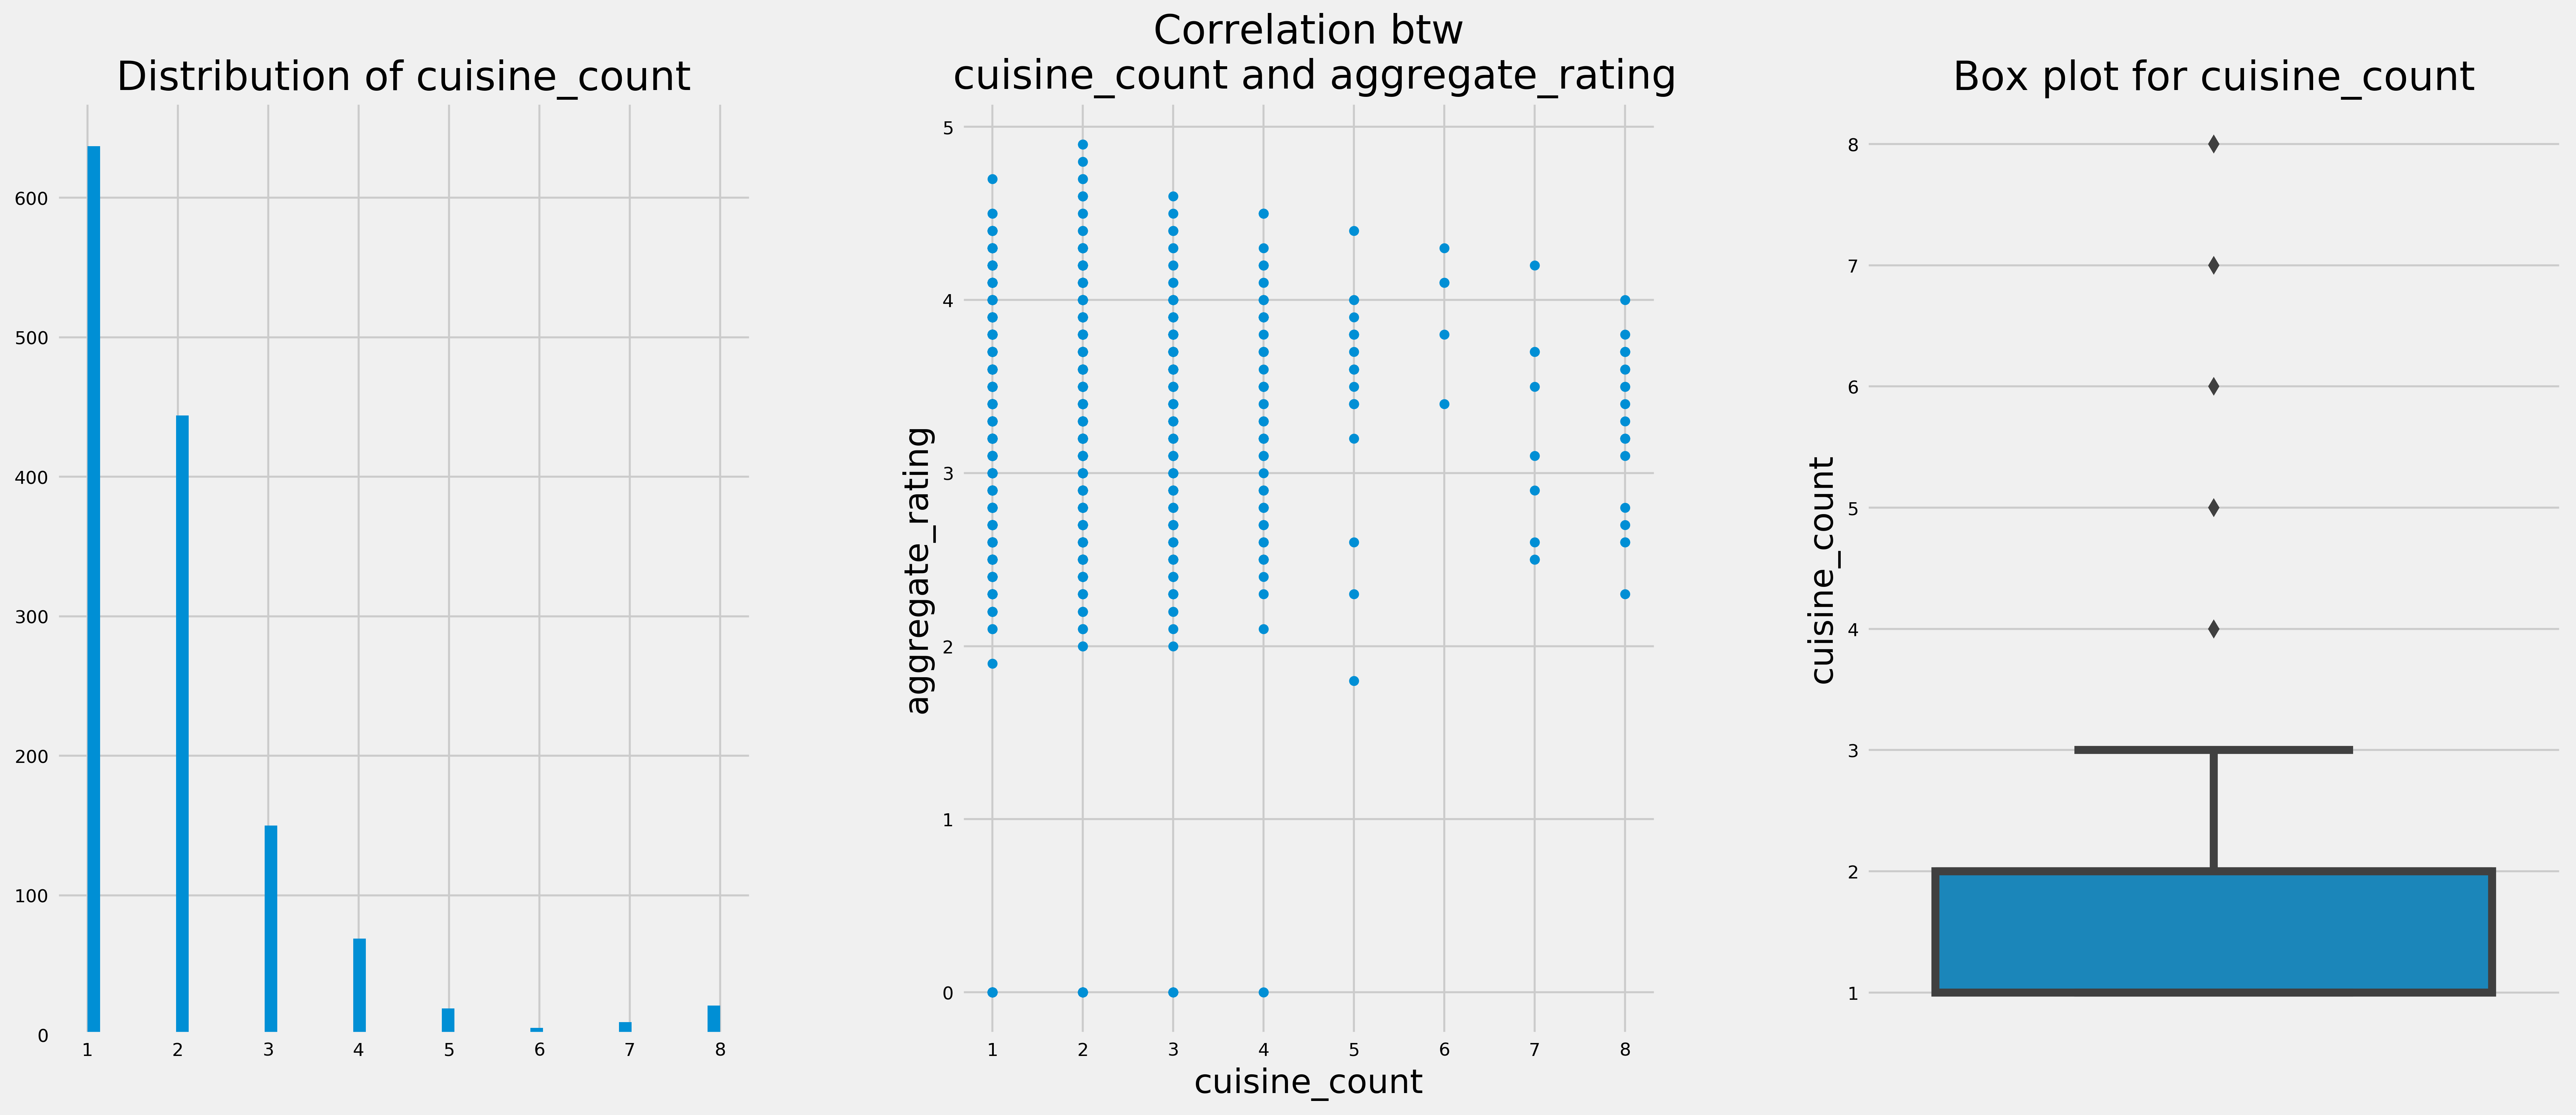

In [167]:
explore_variable(data, "cuisine_count", "aggregate_rating")

Ratings vary across all numbers of cuisines on offer, however it will be useful to see if there are specific trends with low and high scoring restaurants - not in the total cuisines on offer, but rather if specific cuisines do better than others.

## Observations & Actions
- Restaurants with zero rating based on too few votes make it hard to extract useful insight so we'll create a seperate data set for these and take them out of the primary analysis. 
- Some establishments serve drinks only, we'll create a seperate data set for these, but keep them in the original dataset. 

## Extracting Final Analysis Data

In [168]:
zero_rated = data[data.aggregate_rating == 0.0]
print(zero_rated.shape)
zero_rated.head()

(81, 89)


name  aggregate_rating  \
1273                                    Créme de Levain               0.0   
1274  Kristen's Kick Ass Ice Cream- Noordhoek Farm V...               0.0   
1275                                         Milky Lane               0.0   
1276                                             Smooch               0.0   
1277                     Daniela's Deliciously Decadent               0.0   

     rating_text  votes  average_cost_for_two  price_range  \
1273   Not rated      1                   120            2   
1274   Not rated      0                    50            1   
1275   Not rated      1                    80            1   
1276   Not rated      2                    80            1   
1277   Not rated      1                   100            2   

                                       cuisines  cuisine_count  \
1273  Healthy Food, Bakery, Ice Cream, Desserts              4   
1274                        Desserts, Ice Cream              2   
1275                                   Desserts              1   
1276                        Ice Cream, Desserts              2   
1277                           Bakery, Desserts              2   

                             places       locality         ...          \
1273  The Sanctuary Shopping Centre  Somerset West         ...           
1274                           None      Noordhoek         ...           
1275                   N1 City Mall       Goodwood         ...           
1276                Canal Walk Mall   Century City         ...           
1277  Cape Quarter Lifestyle Center    Green Point         ...           

     cuisine_Steak cuisine_Street Food  cuisine_Sushi  cuisine_Tapas  \
1273             0                   0              0              0   
1274             0                   0              0              0   
1275             0                   0              0              0   
1276             0                   0              0              0   
1277             0                   0              0              0   

      cuisine_Tea  cuisine_Tex-Mex  cuisine_Thai  cuisine_Turkish  \
1273            0                0             0                0   
1274            0                0             0                0   
1275            0                0             0                0   
1276            0                0             0                0   
1277            0                0             0                0   

      cuisine_Vegetarian  cuisine_Vietnamese  
1273                   0                   0  
1274                   0                   0  
1275                   0                   0  
1276                   0                   0  
1277                   0                   0  

[5 rows x 89 columns]

In [169]:
print("Data shape before removing rows:", data.shape)
data = data[data.aggregate_rating != 0.0]
print("Data shape after removing rows:", data.shape)

Data shape before removing rows: (1354, 89)
Data shape after removing rows: (1273, 89)


In [170]:
# non-zero rated drinks establishments.
drinks = data[data.cuisines == "Drinks Only"]
print(drinks.shape)
drinks.head()

(150, 89)


name  aggregate_rating rating_text  votes  \
44              The Gin Bar               4.3   Very Good     66   
97    Fairview Tasting Room               4.1   Very Good     47   
120              Boschendal               4.1   Very Good     34   
180  Steenberg Tasting Room               4.0   Very Good     28   
181   Waterford Wine Estate               4.0   Very Good     23   

     average_cost_for_two  price_range     cuisines  cuisine_count places  \
44                    250            3  Drinks Only              1   None   
97                    100            2  Drinks Only              1   None   
120                   150            2  Drinks Only              1   None   
180                    80            1  Drinks Only              1   None   
181                   100            2  Drinks Only              1   None   

         locality         ...         cuisine_Steak cuisine_Street Food  \
44            CBD         ...                     0                   0   
97          Paarl         ...                     0                   0   
120   Franschhoek         ...                     0                   0   
180         Tokai         ...                     0                   0   
181  Stellenbosch         ...                     0                   0   

     cuisine_Sushi  cuisine_Tapas  cuisine_Tea  cuisine_Tex-Mex  cuisine_Thai  \
44               0              0            0                0             0   
97               0              0            0                0             0   
120              0              0            0                0             0   
180              0              0            0                0             0   
181              0              0            0                0             0   

     cuisine_Turkish  cuisine_Vegetarian  cuisine_Vietnamese  
44                 0                   0                   0  
97                 0                   0                   0  
120                0                   0                   0  
180                0                   0                   0  
181                0                   0                   0  

[5 rows x 89 columns]

# Trend Analysis

## Useful Functions for Analysis

In [175]:
def top(df, n=5, column='aggregate_rating'):
    '''Returns the top n rows of data set df ordered desc'''
    return df.sort_values(by=column, ascending=False)[:n]

def bottom(df, n=5, column='aggregate_rating'):
    '''Returns the bottoms n rows of data set df ordered asc'''
    return df.sort_values(by=column, ascending=True)[:n]

def get_stats(group):
    '''Returns the min, max, count and mean summary statistics for a grouped data set'''
    return {'min': group.min(), 'max': group.max(), 'count': group.count(),
            'mean': group.mean(), 'median': group.median(), 'std': group.std()}

def get_cuisine_cols():
    '''Returns the column names of all the cuisine type column, not including the cuisine_count column'''
    cuisine_cols = [col for col in data.columns.tolist() if col.startswith('cuisine_') and col != 'cuisine_count']
    return cuisine_cols    

## Restaurant Count by Price Range and Region

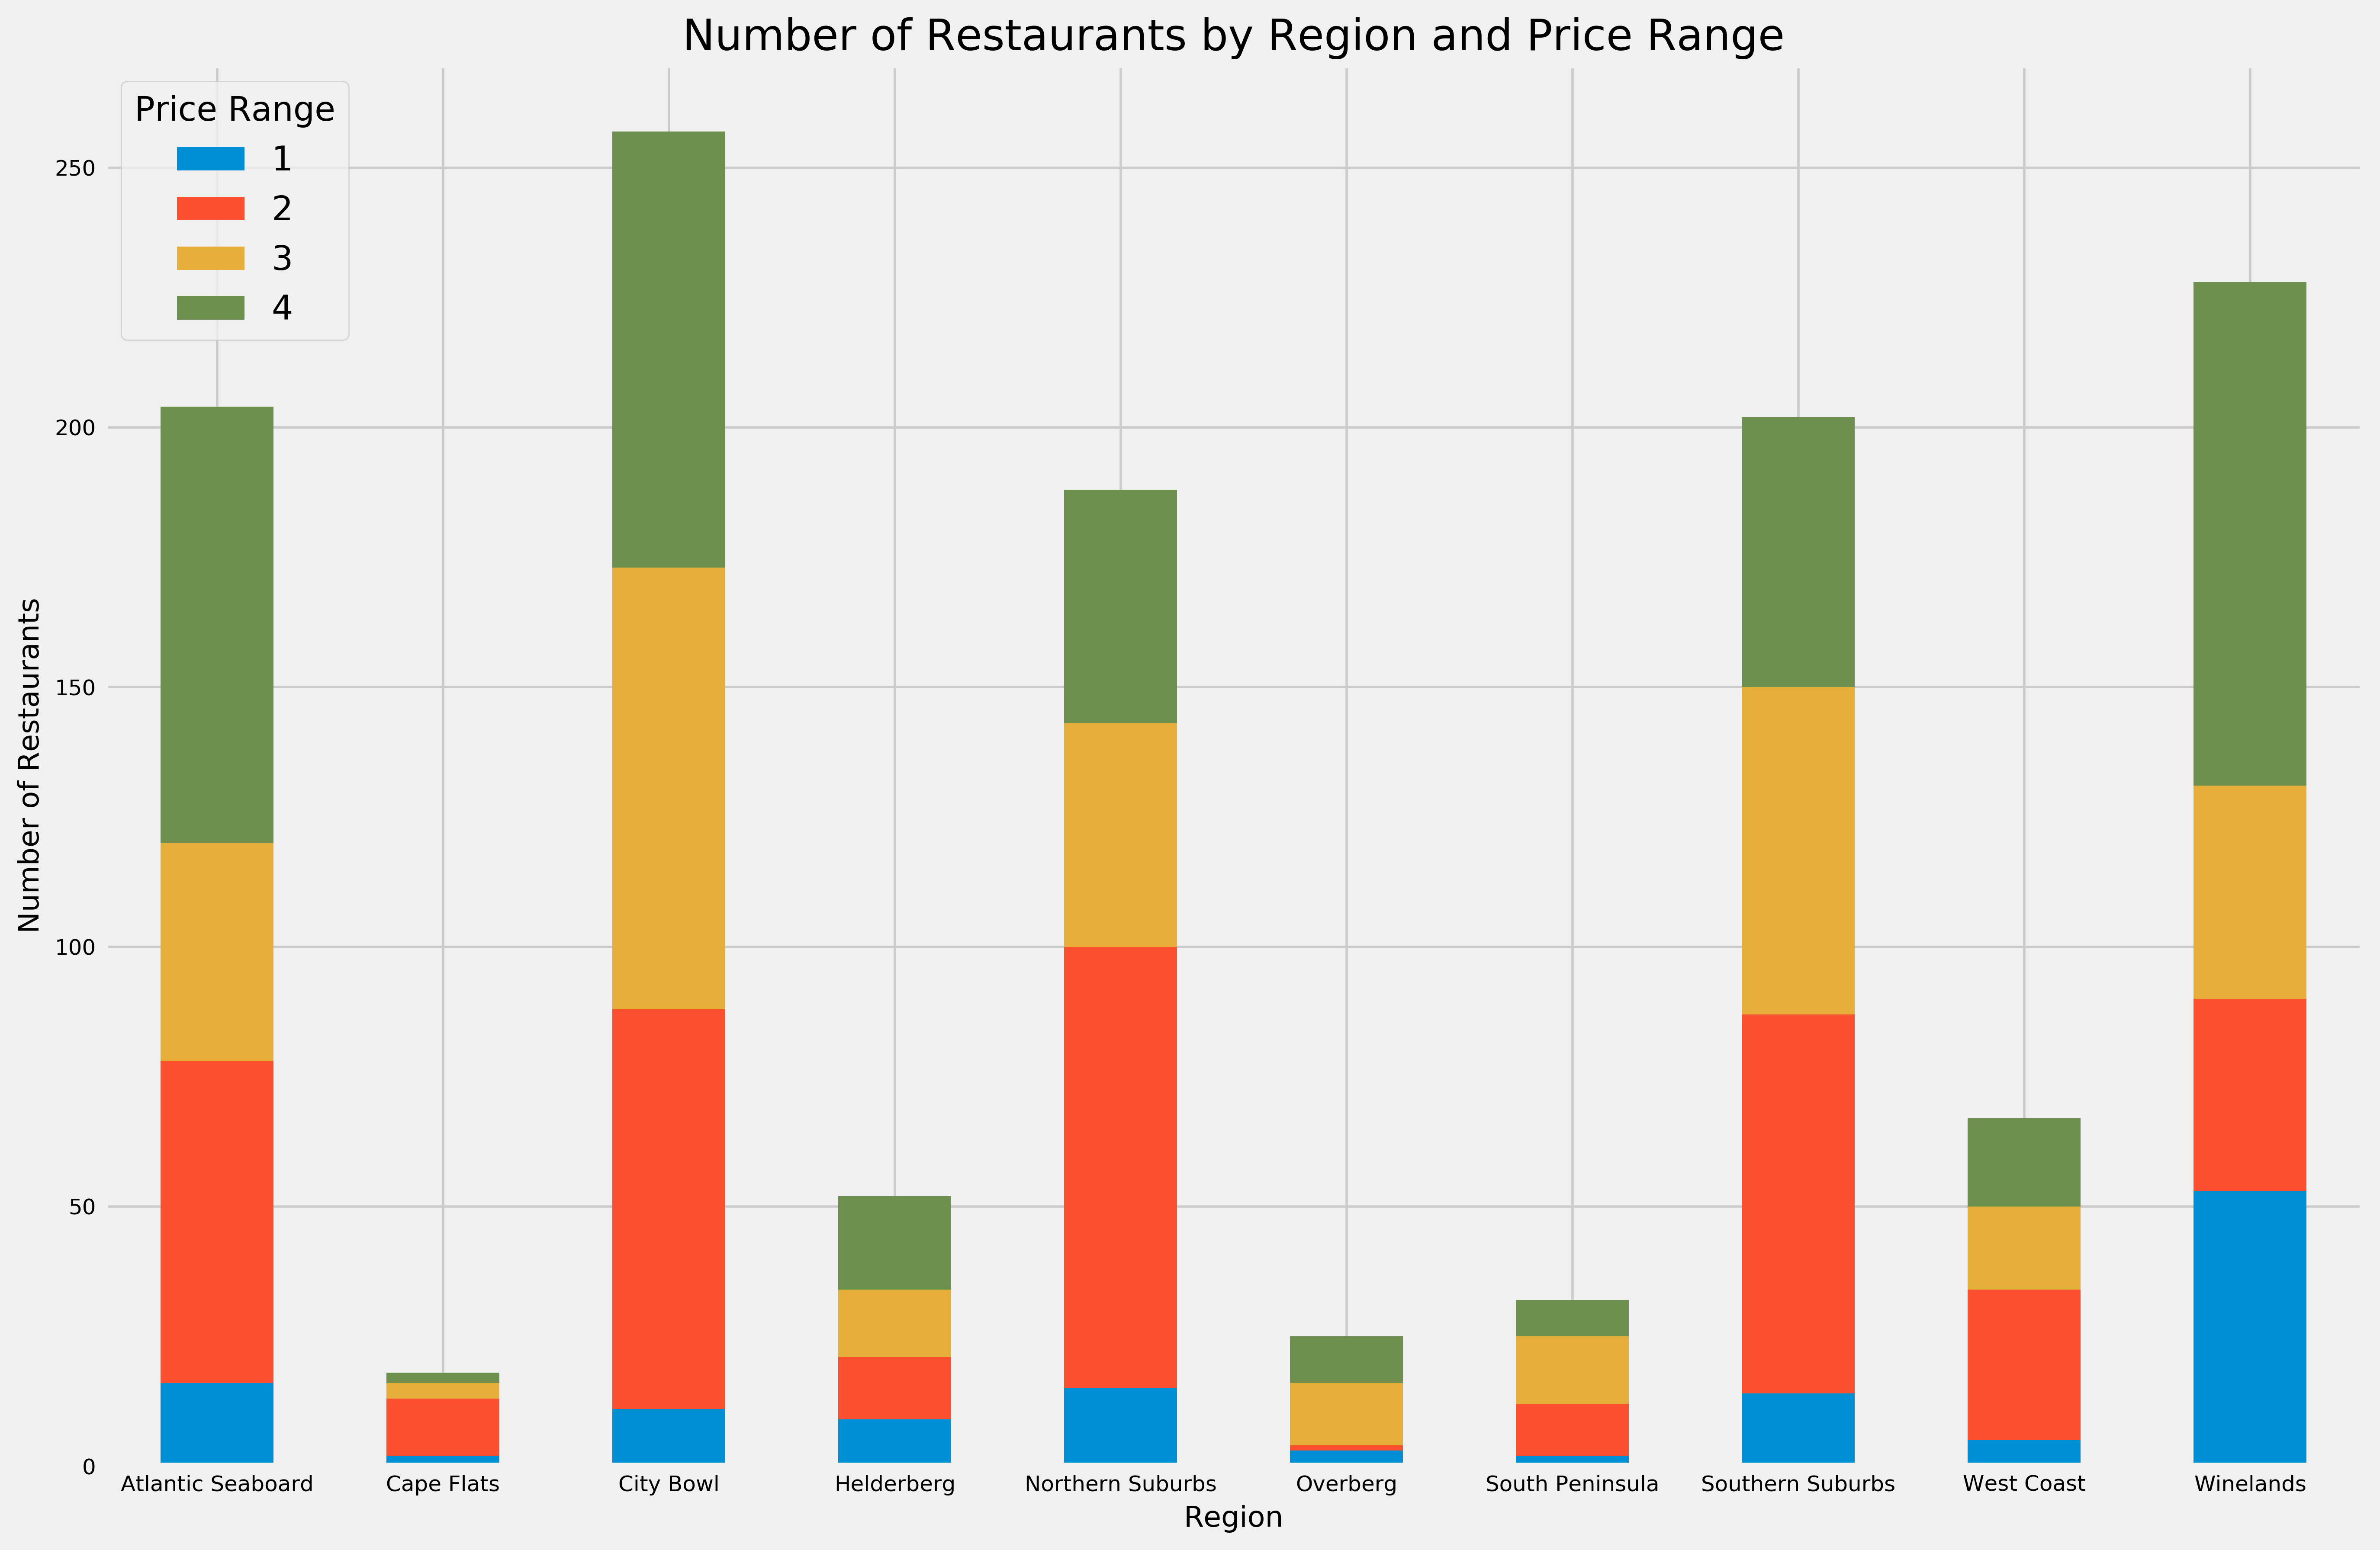

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=400)
ax = pd.crosstab(data.region, data.price_range, margins=False).plot.bar(stacked=True, ax=ax)
ax.set_xlabel("Region")
ax.tick_params(axis="x", labelrotation=0)
ax.set_ylabel("Number of Restaurants")
ax.set_title("Number of Restaurants by Region and Price Range")
ax.legend(title="Price Range")

## Restaurant Rating, Avg Cost for Two and Number of Votes by Price Range and Region

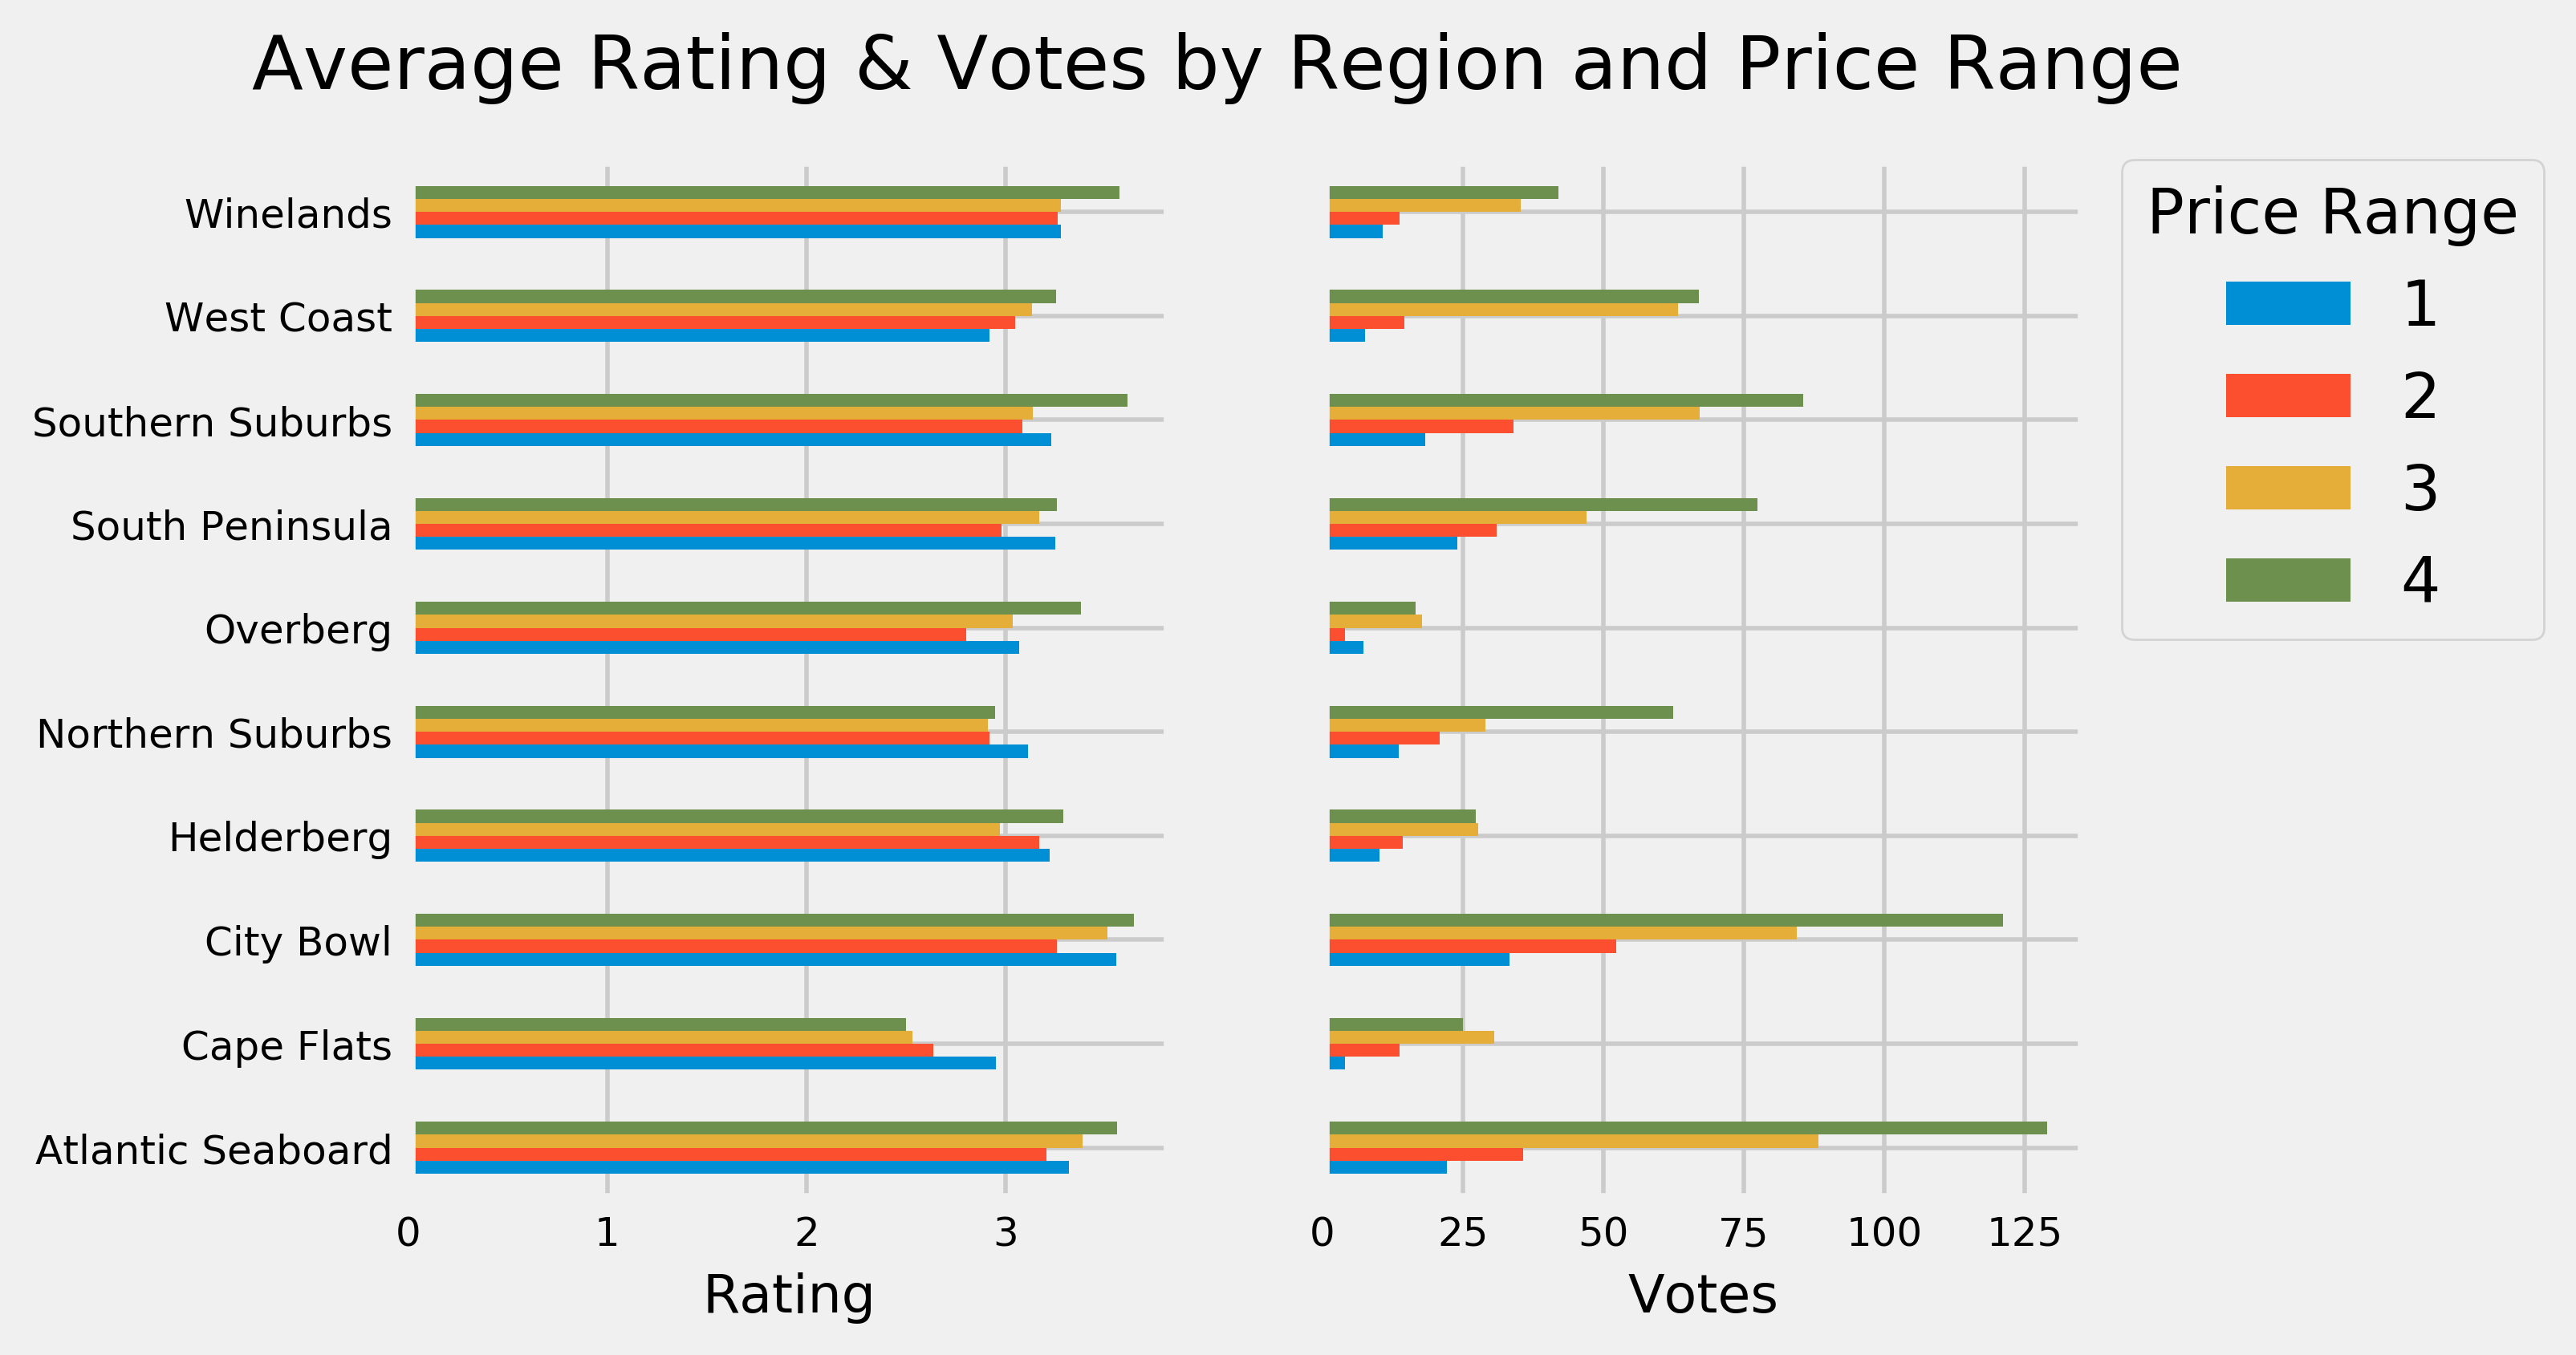

In [227]:
cols = ["aggregate_rating", "votes"]
xlabels = ["Rating", "Votes"]
fig, ax = plt.subplots(1, 2, sharey='row', dpi=400)
#fig.subplots_adjust(hspace=0.2)

for ax, col, xlabel in zip(ax.ravel(), cols, xlabels):
    data.pivot_table(index=["region", "price_range"]).unstack()[col].plot.barh(ax=ax, stacked=False)
    ax.set_xlabel(xlabel)
    if col == "average_cost_for_two":
        ax.xaxis.set_major_formatter(axes_formatter)
    ax.set_ylabel("")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend().set_visible(False)
   
plt.suptitle("Average Rating & Votes by Region and Price Range")
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Price Range")
#save_fig('investment-multiple-years-risks-lump-sum-monthly-contrib')

In [14]:
data[data.region == "Overberg"]["locality"].value_counts()

Hermanus    28
Name: locality, dtype: int64

## Top and Bottom 100 Restaurants by Price Range and Region

In [231]:
def add_top_bottom_identifier(row):
    median = data.aggregate_rating.median()
    if row.aggregate_rating >= median:
        return "Top Half"
    else:
        return "Bottom Half"

data["top_bottom"] = data.apply(add_top_bottom_identifier, axis=1)

In [232]:
data.sample(10)

name  aggregate_rating rating_text  votes  \
43              Honest Chocolate Cafe               4.3   Very Good    252   
1160                       Ciao Bella               2.5     Average     14   
128   The Avenue Restaurant and Grill               4.0   Very Good    129   
1232            Cape Town Fish Market               2.3        Poor     49   
1193                       Cappucinno               2.4        Poor     24   
693                      Vida E Caffe               3.2     Average     11   
1132                            Kauai               2.5     Average     13   
859               Nitida Tasting Room               2.9     Average     11   
534                      Gelato Mania               3.4     Average     14   
778                     Limnos Bakers               3.1     Average     12   

      average_cost_for_two  price_range                  cuisines  \
43                     160            2            Cafe, Desserts   
1160                   250            3                   Italian   
128                    420            4              Grill, Steak   
1232                   350            4  Seafood, Japanese, Sushi   
1193                   220            3           Italian, Burger   
693                    150            2            Cafe, Desserts   
1132                   200            3   Healthy Food, Fast Food   
859                     60            1               Drinks Only   
534                    100            2       Desserts, Ice Cream   
778                    150            2    Cafe, Bakery, Desserts   

      cuisine_count                   places        locality     ...       \
43                2                     None             CBD     ...        
1160              1                     None          Strand     ...        
128               2         Harfield Village       Claremont     ...        
1232              3          Seaside Village  Bloubergstrand     ...        
1193              2                     None   Somerset West     ...        
693               2  Paddock Shopping Centre       Milnerton     ...        
1132              2            Somerset Mall   Somerset West     ...        
859               1                     None     Durbanville     ...        
534               2         Cavendish Square       Claremont     ...        
778               3                     None   Somerset West     ...        

     cuisine_Street Food cuisine_Sushi  cuisine_Tapas  cuisine_Tea  \
43                     0             0              0            0   
1160                   0             0              0            0   
128                    0             0              0            0   
1232                   0             1              0            0   
1193                   0             0              0            0   
693                    0             0              0            0   
1132                   0             0              0            0   
859                    0             0              0            0   
534                    0             0              0            0   
778                    0             0              0            0   

      cuisine_Tex-Mex  cuisine_Thai  cuisine_Turkish  cuisine_Vegetarian  \
43                  0             0                0                   0   
1160                0             0                0                   0   
128                 0             0                0                   0   
1232                0             0                0                   0   
1193                0             0                0                   0   
693                 0             0                0                   0   
1132                0             0                0                   0   
859                 0             0                0                   0   
534                 0             0                0                   0   
778                 0             0

In [263]:
df_top = top(df=data, n=100)
df_bottom = bottom(df=data, n=100)
df = pd.concat([df_top, df_bottom], axis=0)
df

name  aggregate_rating rating_text  votes  \
0                       The Potluck Club               4.9   Excellent    406   
1                             La Colombe               4.9   Excellent    146   
2                            Moro Gelato               4.8   Excellent     72   
3                     Unframed Ice Cream               4.7   Excellent    104   
4                       The Test Kitchen               4.7   Excellent    242   
5                                Jarryds               4.7   Excellent    483   
6                    The Velvet Cake Co.               4.6   Excellent     90   
7                               Foxcroft               4.6   Excellent    103   
8     Chefs Warehouse at Beau Constantia               4.6   Excellent    104   
9                    Warwick Wine Estate               4.6   Excellent    104   
14              Tasting Room at Creation               4.5   Excellent     58   
17                         Four & Twenty               4.5   Excellent    344   
16                          The Creamery               4.5   Excellent    389   
15                              My Sugar               4.5   Excellent    197   
12                      Bistro Sixteen82               4.5   Excellent    214   
13                 The Cousins Trattoria               4.5   Excellent    165   
11                            La Mouette               4.5   Excellent    250   
10                         Giulio's Café               4.5   Excellent    105   
25                          The Foodbarn               4.4   Very Good    137   
30     Greenhouse - The Cellars Hohenort               4.4   Very Good     83   
29                   The Velvet Cake Co.               4.4   Very Good    130   
28                      Burger & Lobster               4.4   Very Good    222   
27                      Willoughby & Co.               4.4   Very Good    587   
26                              El Burro               4.4   Very Good    457   
20                       Constantia Glen               4.4   Very Good    123   
24                Myoga - Vineyard Hotel               4.4   Very Good    140   
23             Chefs Warehouse & Canteen               4.4   Very Good    132   
22                              Homespun               4.4   Very Good    148   
21                       New York Bagels               4.4   Very Good    139   
19                               Pigalle               4.4   Very Good    257   
...                                  ...               ...         ...    ...   
1224                         Mugg & Bean               2.4        Poor    108   
1223                     Life Grand Cafe               2.4        Poor    148   
1221                      Food Inn India               2.4        Poor     84   
1220                              Steers               2.4        Poor     13   
1219                           McDonalds               2.4        Poor     18   
1218                         Cafe Rousse               2.4        Poor     47   
1217                       Sacred Ground               2.4        Poor     45   
1222                       Slaley Bistro               2.4        Poor     22   
1215                              Nino's               2.4        Poor     12   
1214                          Fego Caffe               2.4        Poor     13   
1213                     Green Leaf Cafè               2.4        Poor      9   
1211                         Burger King               2.4        Poor     35   
1210                           McDonalds               2.4        Poor     20   
1209                      Domino's Pizza               2.4        Poor     14   
1216             Melissa's The Food Shop               2.4        Poor     31   
1208                           McDonalds               2.4        Poor     17   
1144                            Snoekies               2.5     Average     14   
1145                               Crave               2.5     Aver

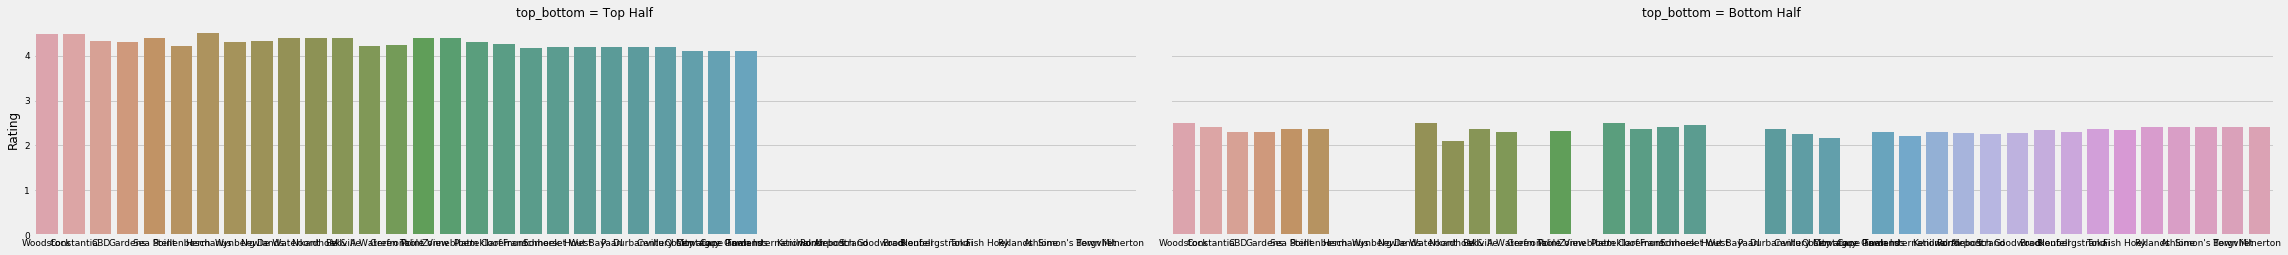

In [265]:
g = sns.factorplot(x="locality", y="aggregate_rating", data=df, col="top_bottom",
                   saturation=.5, kind="bar", ci=None, aspect=4)
(g.set_axis_labels("", "Rating"))

# g = sns.catplot(x="who", y="survived", col="class",
# ...                 data=titanic, saturation=.5,
# ...                 kind="bar", ci=None, aspect=.6)
# >>> (g.set_axis_labels("", "Survival Rate")
# ...   .set_xticklabels(["Men", "Women", "Children"])
# ...   .set_titles("{col_name} {col_var}")
# ...   .set(ylim=(0, 1))
# ...   .despine(left=True))  

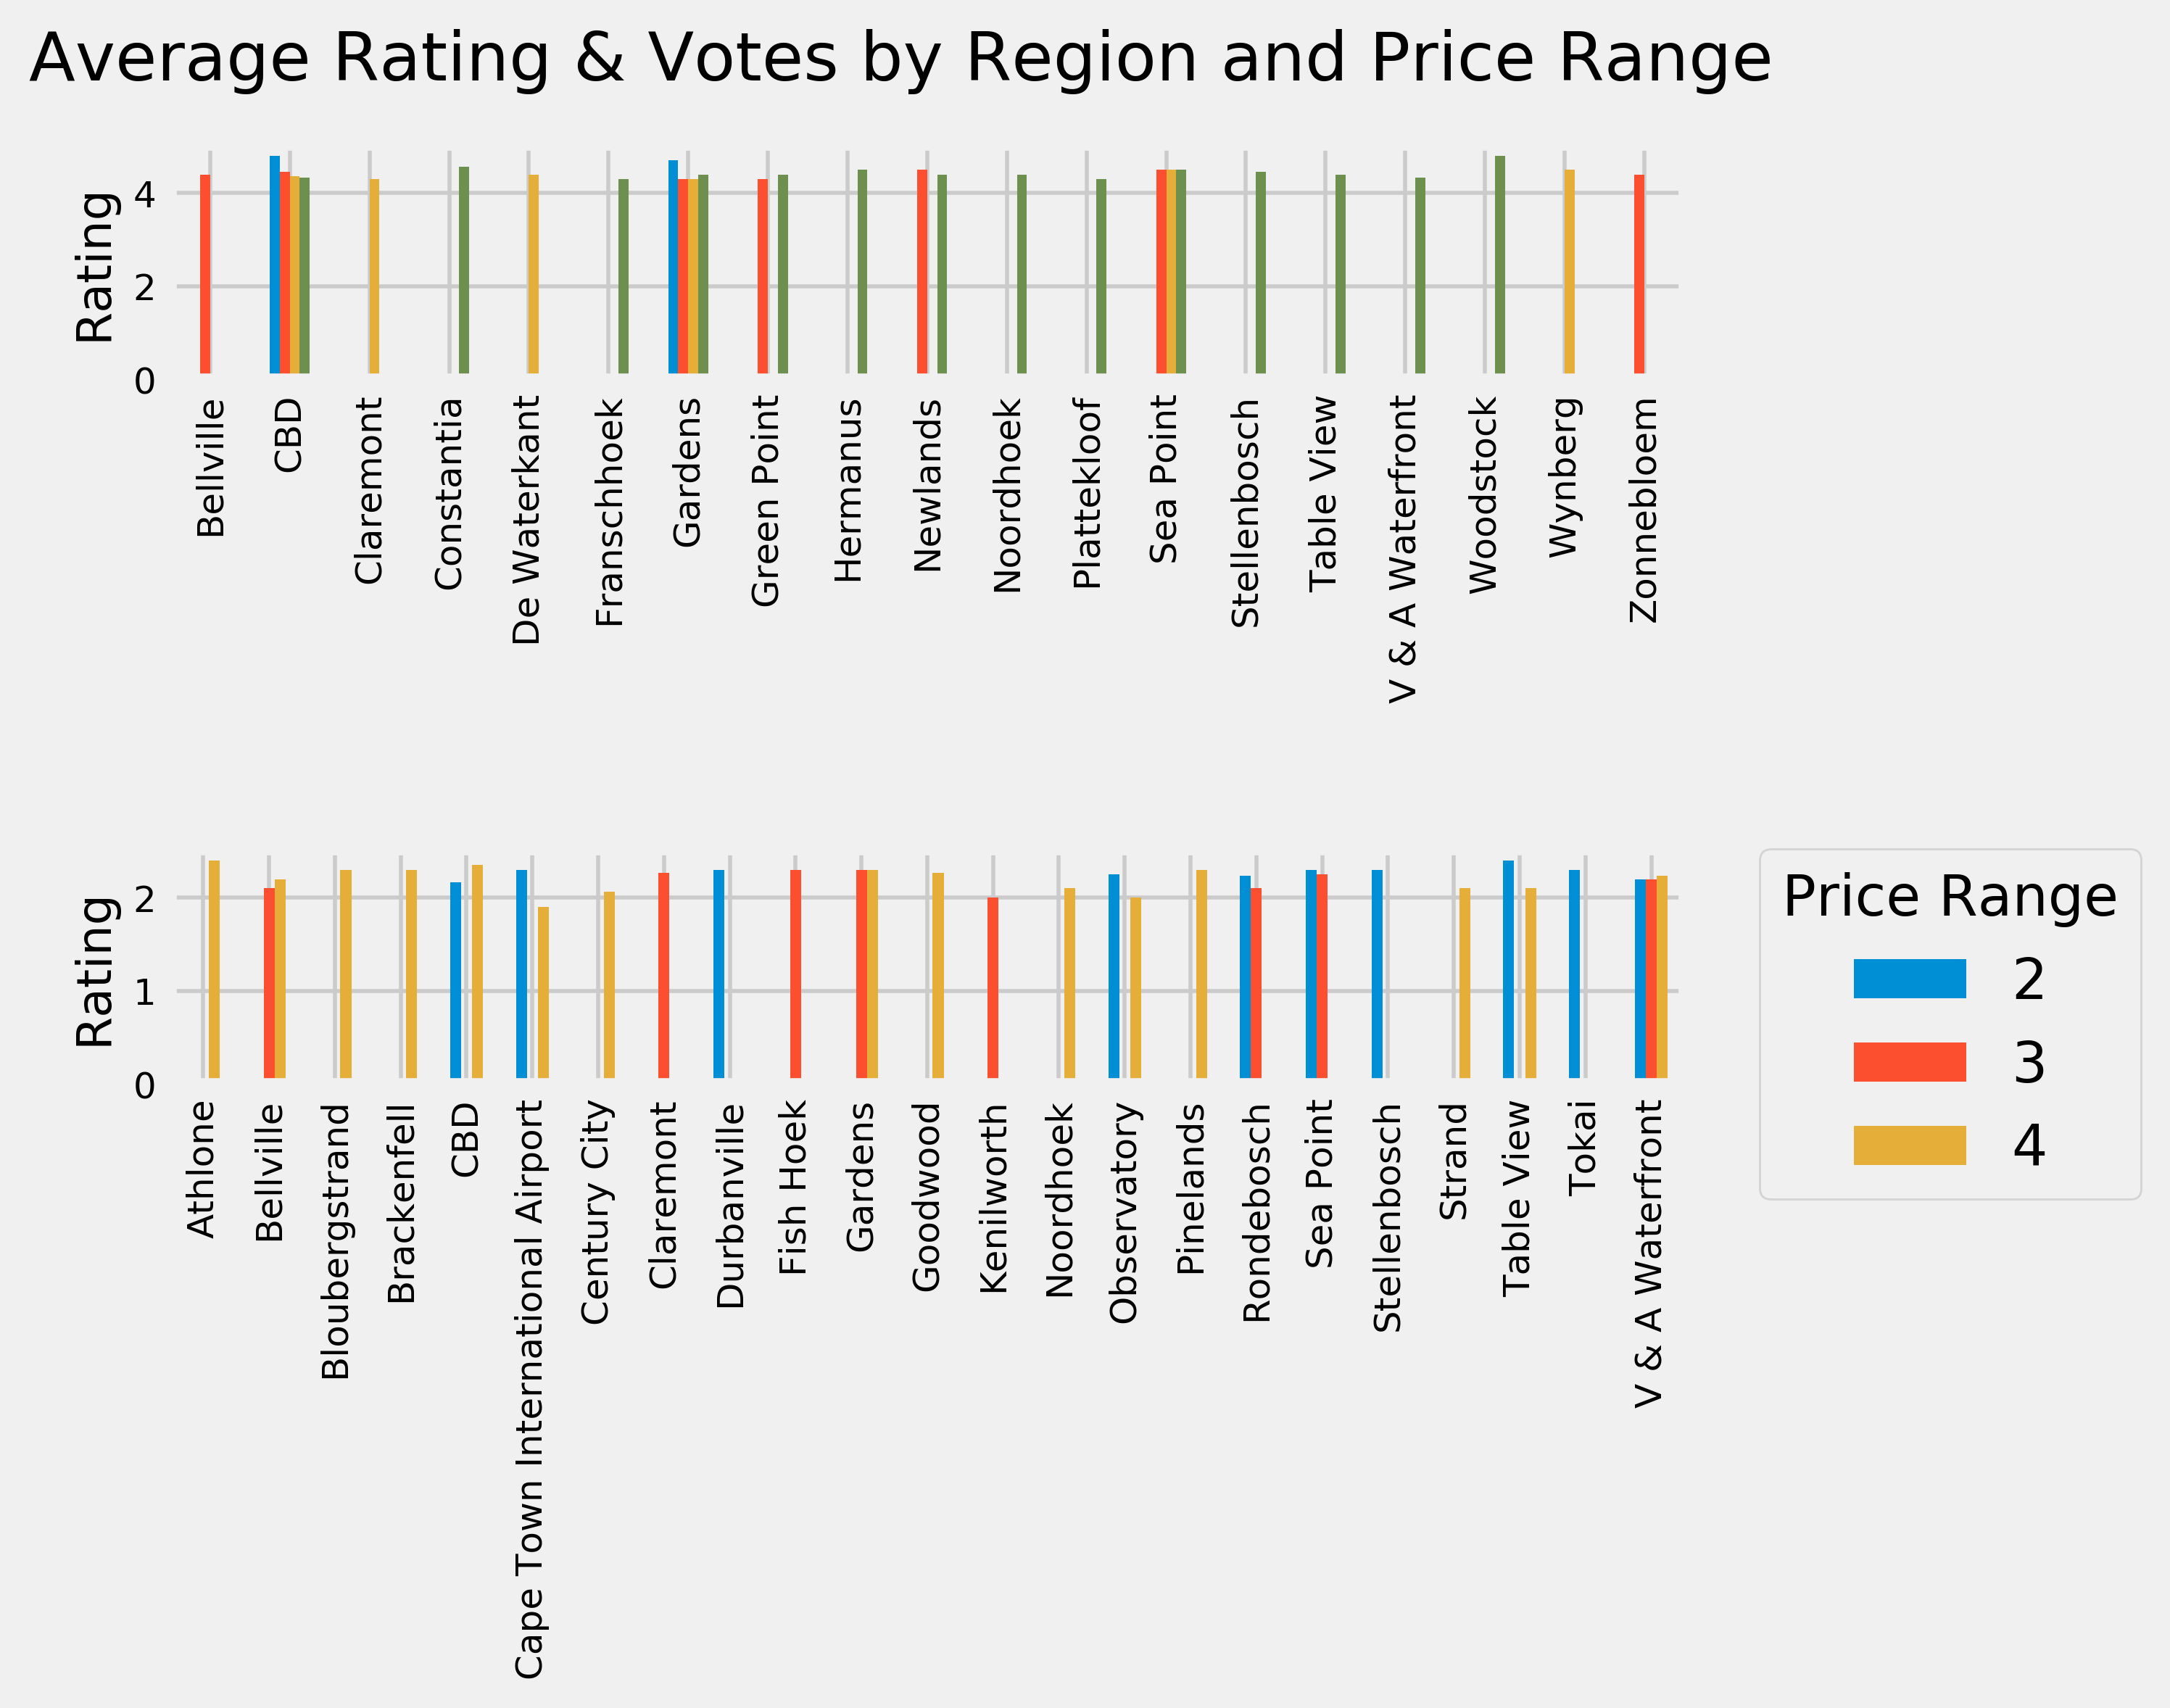

In [282]:
cols = ["aggregate_rating", "aggregate_rating"]
xlabels = ["Rating", "Rating"]
halves = ["Top Half", "Bottom Half"]
fig, ax = plt.subplots(2, 1, sharey='row', dpi=400)
fig.subplots_adjust(hspace=2)

for ax, col, xlabel, half in zip(ax.ravel(), cols, xlabels, halves):
    if half == "Top Half":
        ax = top(df=data[data.top_bottom == half], n=50).pivot_table(index=["locality", "price_range"]).unstack()[col].plot.bar(ax=ax, stacked=False)
    else:
        ax = bottom(df=data[data.top_bottom == half], n=50).pivot_table(index=["locality", "price_range"]).unstack()[col].plot.bar(ax=ax, stacked=False)
    ax.set_xlabel(xlabel)
    if col == "average_cost_for_two":
        ax.xaxis.set_major_formatter(axes_formatter)
    ax.set_ylabel("Rating")
    ax.set_xlabel("")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend().set_visible(False)
   
plt.suptitle("Average Rating & Votes by Region and Price Range")
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Price Range")
#save_fig('investment-multiple-years-risks-lump-sum-monthly-contrib')

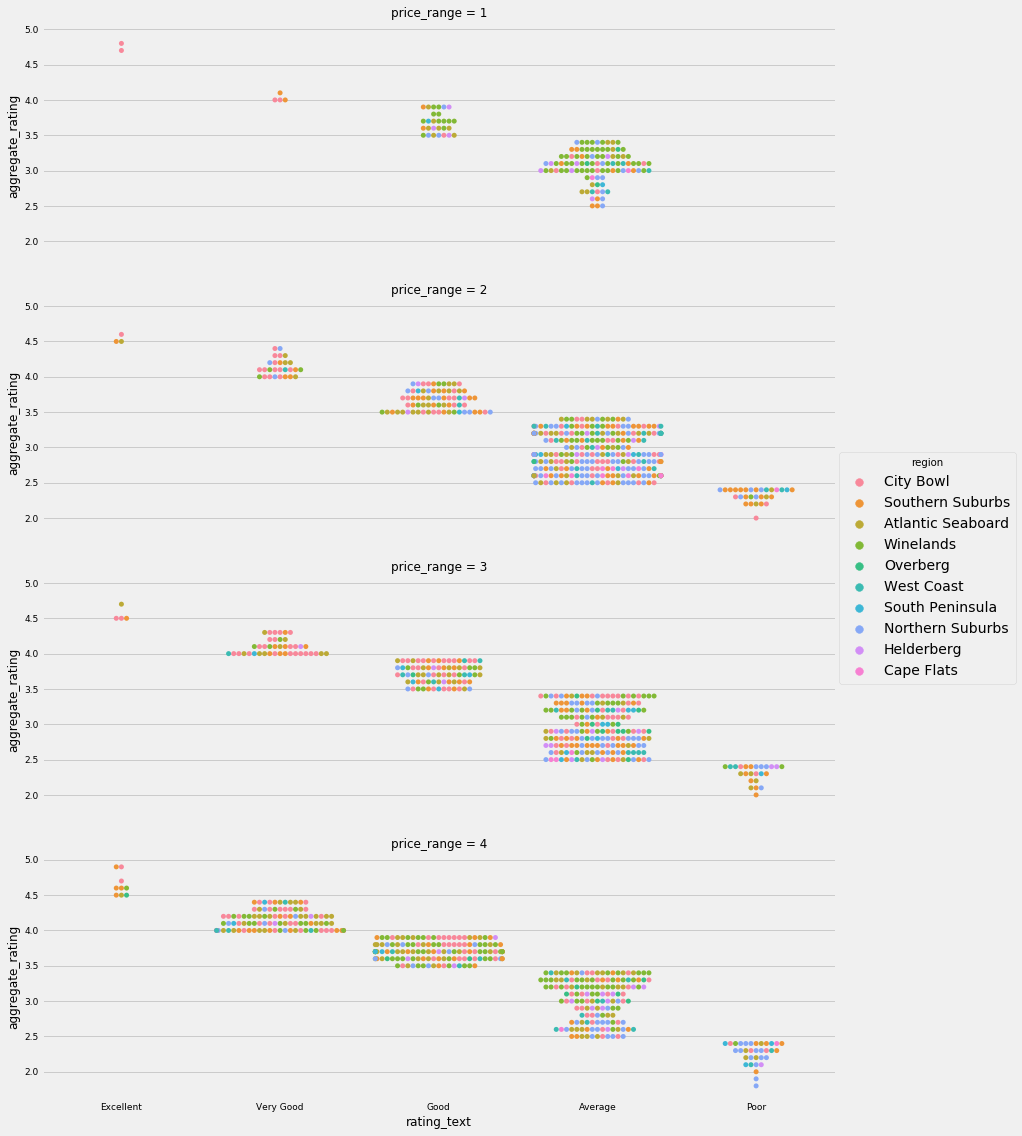

In [294]:
g = sns.factorplot(x="rating_text", y="aggregate_rating", data=data, hue="region", 
                   row="price_range", kind="swarm", aspect=3)